In [1]:
options(repr.plot.width=13, repr.plot.height=8)

install.packages('RCurl')
install.packages('zoo')
suppressPackageStartupMessages({
    require(repr) # Enables resizing of the plots.
    require(RCurl)
    require(foreign)
    require(tidyverse) # To tip the df from long row of dates to cols (pivot_longer())
    require(zoo) # Rolling average
    require(RColorBrewer)
})

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
# Extracting the number of confirmed cumulative cases by country from the Johns Hopkins website:
 
x = getURL("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
corona <- read.csv(textConnection(x))

corona = (read_csv(x,  show_col_types = FALSE)
          %>% pivot_longer(cols = -c(`Province/State`, `Country/Region`, Lat, Long),
                           names_to = "date",
                           values_to = "cases")
          %>% select(`Province/State`,`Country/Region`, date, cases)
          %>% mutate(date=as.Date(date,format="%m/%d/%y"))
          %>% drop_na(cases)
          %>% rename(country="Country/Region", provinces="Province/State")
)

countries <- c("US", "Italy", "Spain", "Sweden", "Brazil", "United Kingdom", "Mexico", "India", "Norway", "Denmark", "Korea, South")
 
cc <- (corona
       %>% filter(country %in% countries)
)
 
ccw <- (cc
        %>% pivot_wider(names_from="country",values_from="cases")
        %>% filter(Italy>5)
)

In [3]:
# Extracting the number of confirmed cumulative cases in China from the Johns Hopkins website:
 
china <- corona[corona$country=='China',]
provinces <- c('Hubei', 'Guangdong', 'Henan', 'Zhejiang', 'Hunan', 'Anhui',
               'Jiangxi','Shandong','Jiangsu','Sichuan','Heilongjiang','Hebei',
               'Fujian','Guangxi','Shaanxi','Yunnan','Hainan','Guizhou','Shanxi',
               'Gansu','Hong Kong','Liaoning','Jilin','Xinjiang','Inner Mongolia',
               'Ningxia','Qinghai','Macau','Tibet')
 
china_prov <- china[is.element(china$provinces,provinces),]
ccchina <- china_prov[,2:4]
temp <- aggregate(ccchina[ ,3], FUN="sum", by=list(as.Date(ccchina$date)))
ccchina[1:nrow(temp),2:3] <- temp 
ccchina <- ccchina[1:nrow(temp),]
 
ccw_china <- (ccchina
              %>% pivot_wider(names_from=country,values_from="cases")
              %>% filter(China>1)
)

In [4]:
# Extracting number of cumulative deaths by country from the Johns Hopkins website:
 
y = getURL("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
corona_death <- read.csv(textConnection(y))
 
corona_death = (read_csv(y, show_col_types = FALSE)
                %>% pivot_longer(cols = -c(`Province/State`, `Country/Region`, Lat, Long),
                                 names_to = "date",
                                 values_to = "cases")
                %>% select(`Province/State`, `Country/Region`, date, cases)
                %>% mutate(date=as.Date(date,format="%m/%d/%y"))
                %>% drop_na(cases)
                %>% rename(country="Country/Region")
                %>% rename(state="Province/State")
)
 
ccd <- (corona_death
        %>% filter(country %in% countries)
)
 
ccwd <- (ccd
         %>% pivot_wider(names_from="country",values_from="cases")
         %>% filter(Italy>1)
)

In [5]:
# Extracting the number of cumulative deaths in China from the Johns Hopkins website:
 
china <- corona_death[corona_death$country=='China',]
provinces <- c('Hubei', 'Guangdong', 'Henan', 'Zhejiang', 'Hunan', 'Anhui',
               'Jiangxi','Shandong','Jiangsu','Sichuan','Heilongjiang','Hebei',
               'Fujian','Guangxi','Shaanxi','Yunnan','Hainan','Guizhou','Shanxi',
               'Gansu','Hong Kong','Liaoning','Jilin','Xinjiang','Inner Mongolia',
               'Ningxia','Qinghai','Macau','Tibet')
china_prov <- china[is.element(china$state,provinces),]
ccchina <- china_prov[,2:4]
temp <- aggregate(ccchina[ ,3], FUN="sum", by=list(as.Date(ccchina$date)))
 
ccchina[1:nrow(temp),2:3] <- temp 
ccchina <- ccchina[1:nrow(temp),]

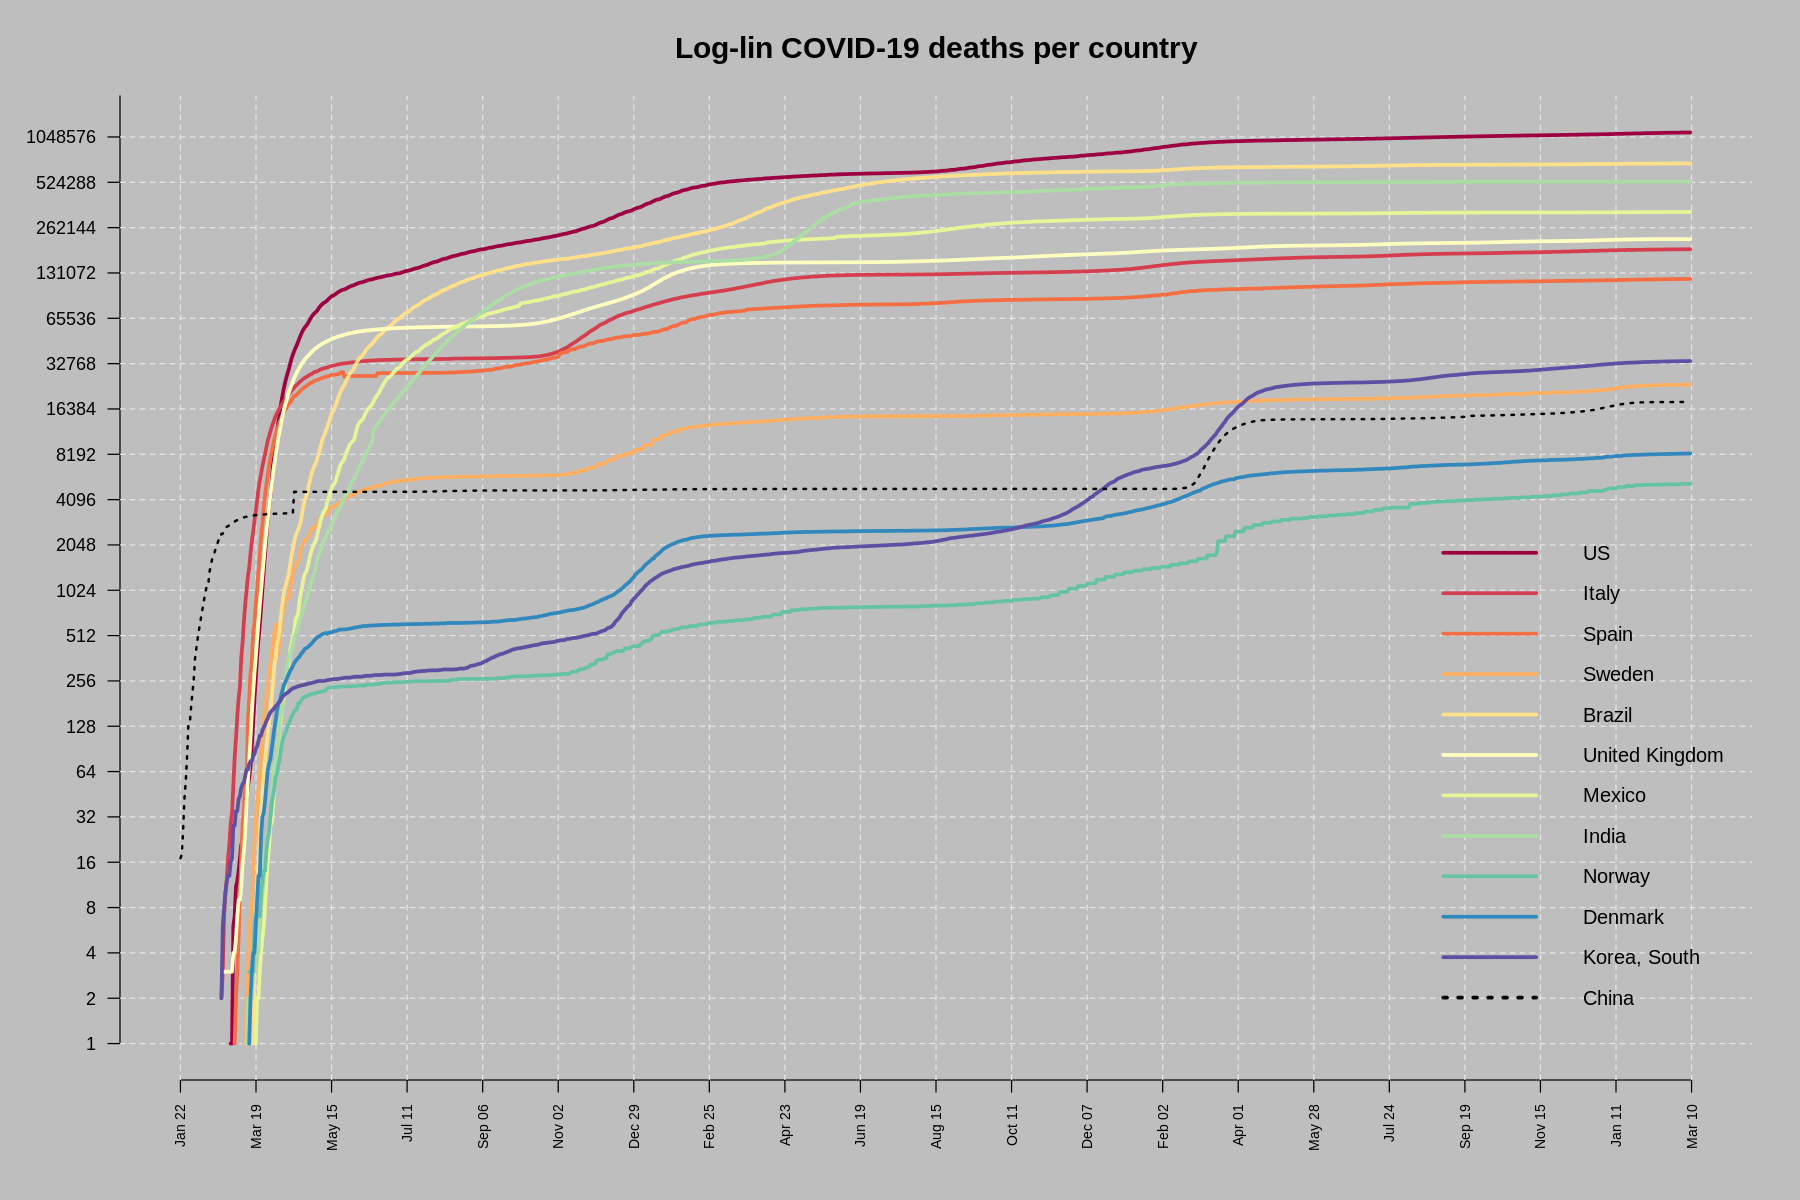

In [6]:
# Log-linear plot of cumulative deaths by country with the number of cases in Italy for comparison:

options(repr.plot.width=15, repr.plot.height=10)
options(warn = -1)
par(mar=c(5,5,4,2))
par(bg = 'gray')


co <- brewer.pal(n = length(countries), name = 'Spectral')

no.uno <- names(ccwd[,-c(1,2)])[which.max(tail(ccwd[,-c(1,2)],1))]

plot(ccwd$date, pull(ccwd[,no.uno]), type="n", 
     ylab='', 
     xlab='',
     log='y',
     xlim=c(min(ccchina$date), max(ccwd$date)+1),
     main ='Log-lin COVID-19 deaths per country',
     col=co[1],
     axes=FALSE,
     cex.main=1.5)
 

at1 <- seq(min(ccchina$date), max(ccchina$date)+1, by=0.05*length(ccchina$date))
axis.Date(1, at=at1, format="%b %d", las=2, cex.axis=0.7)

at2 <- 2^seq(0,30, by=1)
axis(side=2, at2, cex.axis=0.9, las=1)
 

abline(h=at2, lty=2, col="grey90")  # Add faint grid lines
abline(v=at1, lty=2, col="grey90")  # Add faint grid lines

for(i in 1:length(countries)) lines(ccwd$date, pull(ccwd[,countries[i]]), lwd=3, col=co[i])

lines(ccchina$date, ccchina$cases, type="l", lty=3, lwd=2)

legend(ccwd$date[round(0.8*length(ccwd$date))], 0.003*max(pull(ccwd[,no.uno])), bg="transparent",
       legend = c(countries,"China"),
       col = c(co[1:(length(countries))],"black"), lty=c(rep(1,length(countries)),3), lwd=3, cex=1,
       box.lty=0)

[1] "The total number of deaths in the US is 1,123,836 ."

[1] "The fatality rate in the US is 1.1 percent."

[1] "The total number of deaths in the SK is 34,093 ."

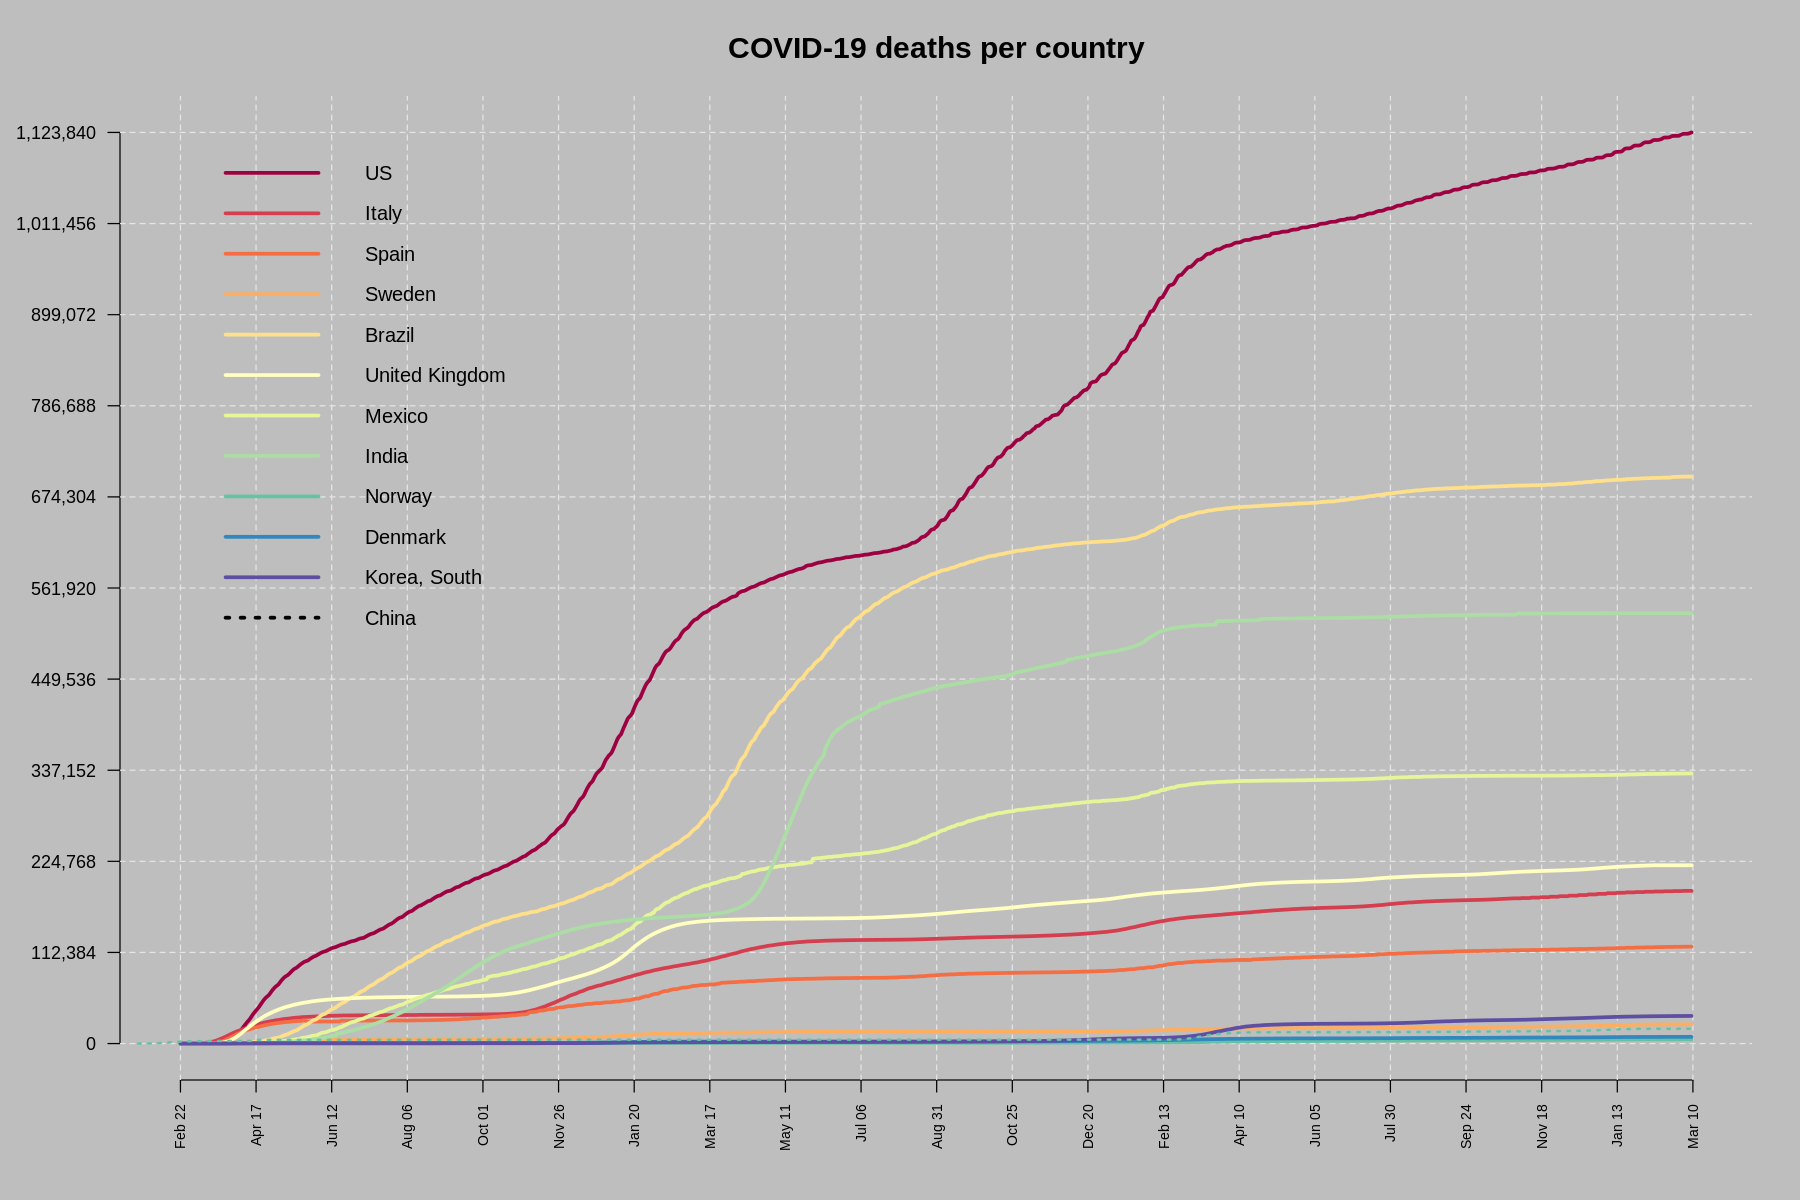

In [7]:
# Plot of the cumulative number of deaths per country:

par(mar=c(5,5,4,2))
par(bg = 'gray')
plot(ccwd$date, pull(ccwd[,no.uno]), type="no", 
     ylab='', 
     xlab='',
     main='COVID-19 deaths per country',
     col=co[1],
     axes=FALSE,
     cex.main=1.5)
 
at1 <- seq(min(ccwd$date), max(ccwd$date)+5, by=0.05*length(ccwd$date))
axis.Date(1, at=at1, format="%b %d", las=2, cex.axis=0.7)
 
at2 <- seq(0,max(pull(ccwd[,no.uno]))+.1*max(pull(ccwd[,no.uno])),by=round(.1*max(pull(ccwd[,no.uno]))))
axis(side=2, at2, labels = formatC(at2, big.mark = ",", format = "d"), cex.axis=0.9, las=1)
 
abline(h=at2, lty=2, col="grey90")  # Add faint grid lines
abline(v=at1, lty=2, col="grey90")  # Add faint grid lines

for(i in 1:length(countries)) lines(ccwd$date, pull(ccwd[,countries[i]]), lwd=3, col=co[i])

lines(ccchina$date, ccchina$cases,      lty=3, lwd=2, col=co[9])

legend(ccw$date[1], max(pull(ccwd[,no.uno])), bg="transparent",
       legend = c(countries,"China"),
       col = c(co[1:(length(countries))],"black"), 
       lty=c(rep(1,length(countries)),3), 
       lwd=3, cex=1,
       box.lty=0)

paste("The total number of deaths in the US is", format(tail(ccwd$US,1),format="d",big.mark=","),".")
paste("The fatality rate in the US is", round(tail(ccwd$US,1) / tail(ccw$US,1) * 100,1),"percent.")
paste("The total number of deaths in the SK is", format(tail(ccwd$`Korea, South`,1),format="d",big.mark=","),".")

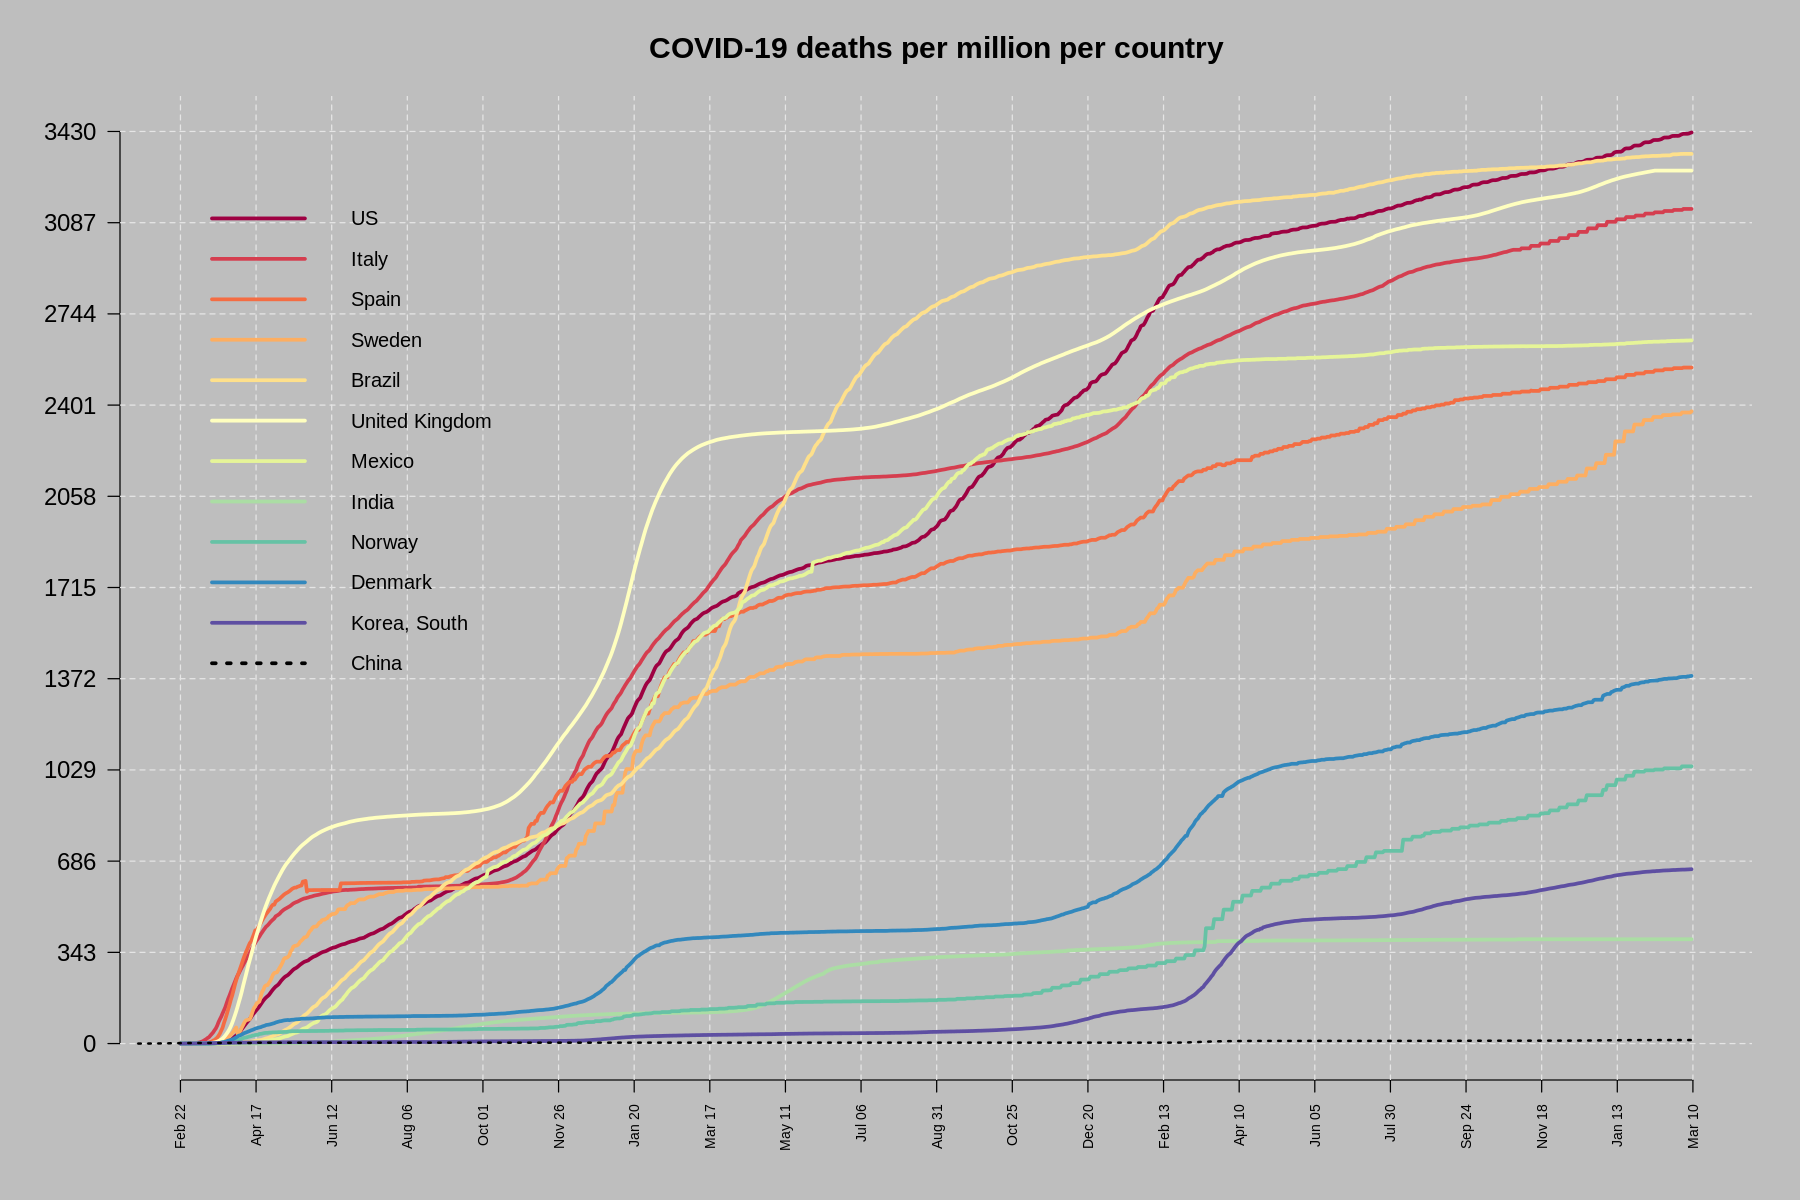

In [8]:
# Plot of the cumulative number of deaths per million per country (per 100,000):

populations <- c(popUS <- 328, popItaly  <- 60 , popSpain  <- 47, popSweden <- 10, 
                popBrazil <- 209, popUK  <- 67, popMex <- 126, popIndia  <- 1353, 
                popNorw <- 5, popDen <- 6, popSK <- 52)

popChina  <- 1393

ranking <- c(US=max(ccwd$US/popUS), Italy=max(ccwd$Italy/popItaly), Spain=max(ccwd$Spain/popSpain), Sweden=max(ccwd$Sweden/popSweden), 
            Brazil=max(ccwd$Brazil/popBrazil), `United Kingdom`=max(ccwd$`United Kingdom`/popUK), 
            Mexico=max(ccwd$Mexico/popMex), India=max(ccwd$India/popIndia), 
            Norway=max(ccwd$Norway/popNorw), Denmark=max(ccwd$Denmark/popDen),
            `Korea, South`=max(ccwd$`Korea, South`/popSK))

y.axis <- pull(ccwd[,names(which.max(ranking))])/populations[which.max(ranking)]

par(mar=c(5,5,4,2))
par(bg = 'gray')
plot(ccwd$date, y.axis, type="n",
     ylab='', 
     xlab='',
     main ='COVID-19 deaths per million per country',
     axes=FALSE,
     cex.main=1.5)
 
at1 <- seq(min(ccwd$date), max(ccwd$date)+5, by=0.05*length(ccwd$date))
axis.Date(1, at=at1, format="%b %d", las=2, cex.axis=0.7)

at2 <- seq(0, max(ranking)+.1*max(ranking),by=round(.1*max(ranking)))
axis(side=2, at2, cex.axis=1.2, las=1)
 
abline(h=at2, lty=2, col="grey90")  # Add faint grid lines
abline(v=at1, lty=2, col="grey90")  # Add faint grid lines

for(i in 1:length(countries)) lines(ccwd$date, pull(ccwd[,countries[i]]/populations[i]), lwd=3, col=co[i])

lines(ccchina$date, ccchina$cases/popChina, lty=3, lwd=2)

legend(ccw$date[1] - 10, 0.95*max(ranking), bg="transparent",
       legend = c(countries,"China"),
       col = c(co[1:(length(countries))],"black"), 
       lty=c(rep(1,length(countries)),3), 
       lwd=3, cex=1,
       box.lty=0)

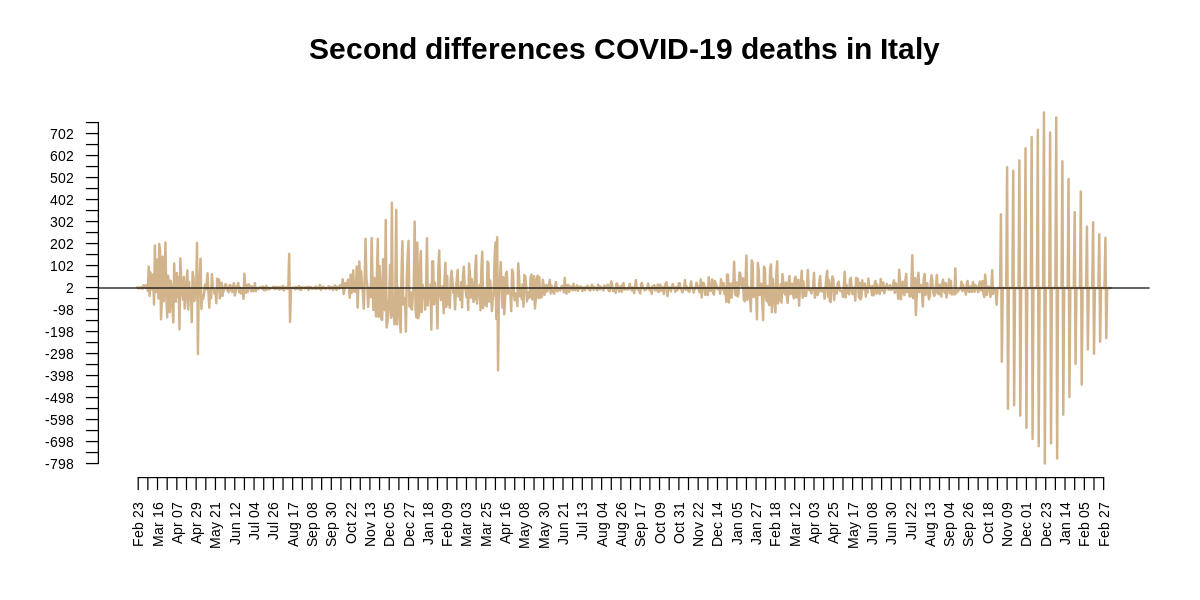

In [9]:
# Analyzing second differences in the number of deaths in Italy:

options(repr.plot.width=10, repr.plot.height=5)


first.der<-diff(ccwd$Italy, lag = 1, differences = 1)
#lag = 1 means that the differences are taken between adjacent elements in the vector.
#differences = 1 means that only one difference is taken.
sec.der <- diff(ccwd$Italy, lag = 1, differences = 2)
#differences = 2 means that after taking the difference between adjacent elements (lag = 1)...
#a difference between adjacent differences is taken. It is the same as diff(diff(...))

plot(ccwd$date[2:length(ccwd$date)-2], sec.der, 
     type="l", lwd=2, lty=1,
     ylab='', 
     xlab='',
     main ='Second differences COVID-19 deaths in Italy',
     col="tan",
     axes=FALSE,
     cex.main=1.5)
abline(h=0)
at1 <- seq(min(ccw$date)+2, max(ccw$date), by=round(0.01*length(ccw$date)))
axis.Date(1, at=at1, format="%b %d", las=2, cex.axis=0.7)
axis(side=2, seq(min(sec.der),max(sec.der),50), 
     las=2, cex.axis=0.7)

#require(tseries)
#require(forecast)
#require(astsa)
#dif<-diff(ccwdpred$Italy)
#fit = auto.arima(dif)
#pred = predict(fit, n.ahead = 50)
#ts.plot(dif, pred$pred, lty = c(1,3), col=c(5,2))
#gtemp_pred<-gtemp[length(gtemp)]
#for(i in 1:length(pred$pred)){
#  gtemp_pred[i+1]<-gtemp_pred[i]+pred$pred[i]
#}
#plot(c(gtemp,gtemp_pred),type="l")

[1] "The number of deaths per million in Spain is  2542 ."

[1] "The number of deaths per million in the US is  3426 ."

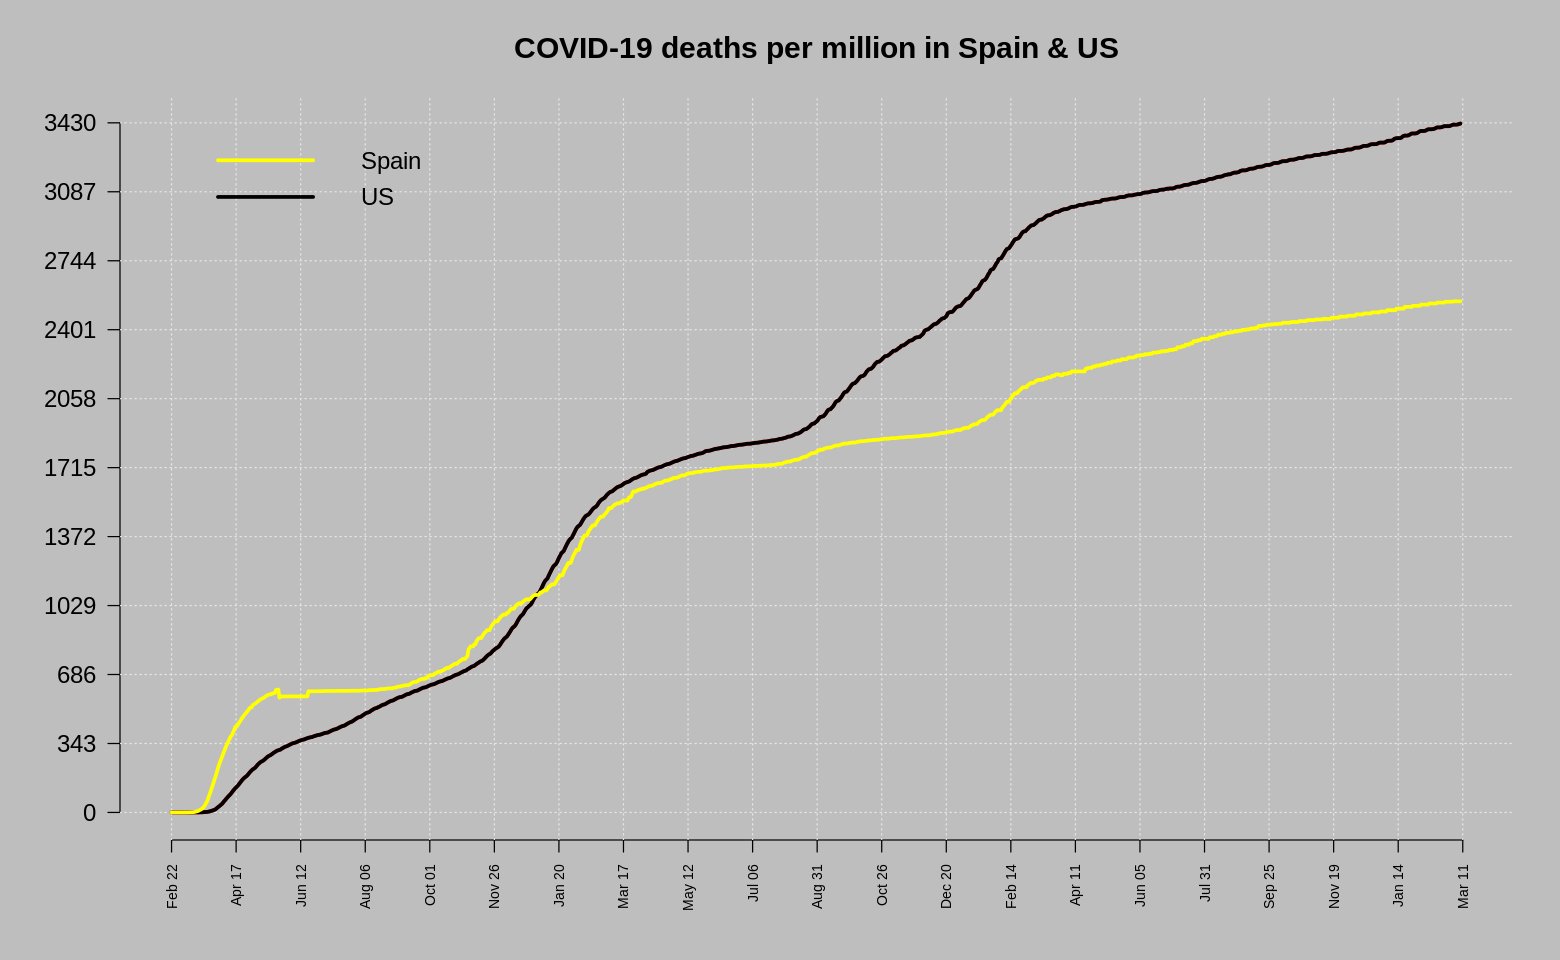

In [10]:
# Deaths per million US vs Spain

options(repr.plot.width=13, repr.plot.height=8)
par(mar=c(5,5,4,2))
par(bg = 'gray')

ranking2 <- c(US=max(ccwd$US/popUS), Spain=max(ccwd$Spain/popSpain))
populations2 <- c(popUS, popSpain)
y.axis <- pull(ccwd[,names(which.max(ranking2))])/populations2[which.max(ranking2)]


plot(ccwd$date, y.axis, type="l", lwd=3, lty=1,
     ylab='', 
     xlab='',
     main ='COVID-19 deaths per million in Spain & US',
     col="red",
     axes=FALSE,
     cex.main=1.5)
 
at1 <- seq(min(ccwd$date), max(ccwd$date)+5, by=0.05*length(ccw$date))
axis.Date(1, at=at1, format="%b %d", las=2, cex.axis=0.7)

top <- max(pull(ccwd[,names(which.max(ranking2))])/populations2[which.max(ranking2)])
at2 <- seq(0, top +.1*top , by=round(.1*top))
axis(side=2, at2, cex.axis=1.2, las=1)
 
abline(h=at2, lty=3, col="grey90")  # Add faint grid lines
abline(v=at1, lty=3, col="grey90")  # Add faint grid lines
 
lines(ccwd$date, ccwd$US/popUS,       lwd=3, col="black")
lines(ccwd$date, ccwd$Spain/popSpain, lwd=3, col="yellow")

legend(ccw$date[1], max(ccwd$US/popUS), bg="transparent",
       legend=c("Spain", "US"),
       col=c("yellow", "black"), lwd=3, cex=1.2,
       box.lty=0)

paste("The number of deaths per million in Spain is ", round(max(ccwd$Spain/popSpain)),".")
paste("The number of deaths per million in the US is ", round(max(ccwd$US/popUS)),".")

[1] "The number of deaths in the last day in the US is 590 ."

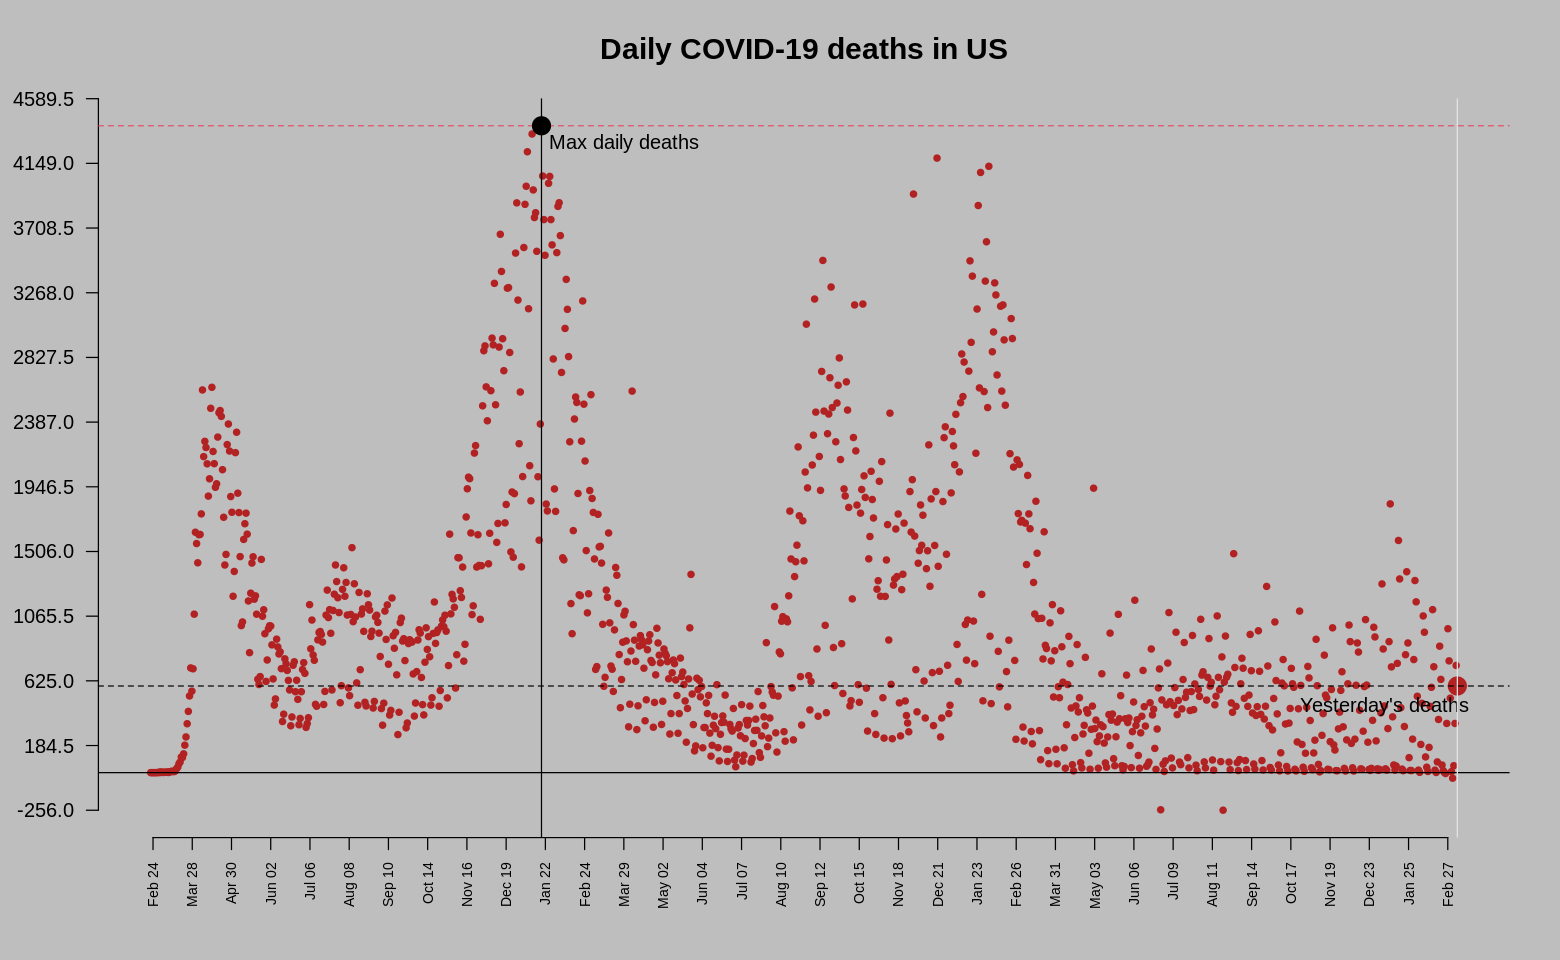

In [11]:
f.der<-diff(ccwd$US, lag = 1, differences = 1)

par(bg = 'gray')
plot(ccwd$date[2:length(ccwd$date)-1], f.der, 
     pch = 19, cex = 0.7,
     ylab='', 
     xlab='',
     main ='Daily COVID-19 deaths in US',
     col='firebrick',
     axes=FALSE,
     cex.main=1.5)

points(ccwd$date[length(ccwd$date)-1], last(f.der), pch=19, cex=2, col='firebrick')
legend(ccwd$date[length(ccwd$date)-1]-200, last(f.der)+80, bg="transparent",
       legend=c("Yesterday's deaths"), box.lty=0)

abline(h=0)
abline(v=ccwd$date[length(ccwd$date)-1], col='gray90')
abline(h=f.der[length(ccwd$date)-1], col=, lty=2)

at1 <- seq(min(ccwd$date)+2, max(ccwd$date), by= 0.03 * (max(ccwd$date) - min(ccwd$date)))
axis.Date(1, at=at1, format="%b %d", las=2, cex.axis=0.7)

axis(side=2, seq(min(f.der),max(f.der)+500, 0.1*max(f.der)), 
     las=2, cex.axis=1)

abline(h=max(f.der), col=2, lty=2)
abline(v=ccwd$date[which.max(f.der)])
points(ccwd$date[which.max(f.der)], f.der[which.max(f.der)], pch=19, cex=2, col=1)
legend(ccwd$date[which.max(f.der)]-60, f.der[which.max(f.der)]+100, bg="transparent", text.col=1,
       legend=c("Max daily deaths"), box.lty=0)

paste("The number of deaths in the last day in the US is", format(tail(f.der,1),format="d",big.mark=","), ".")

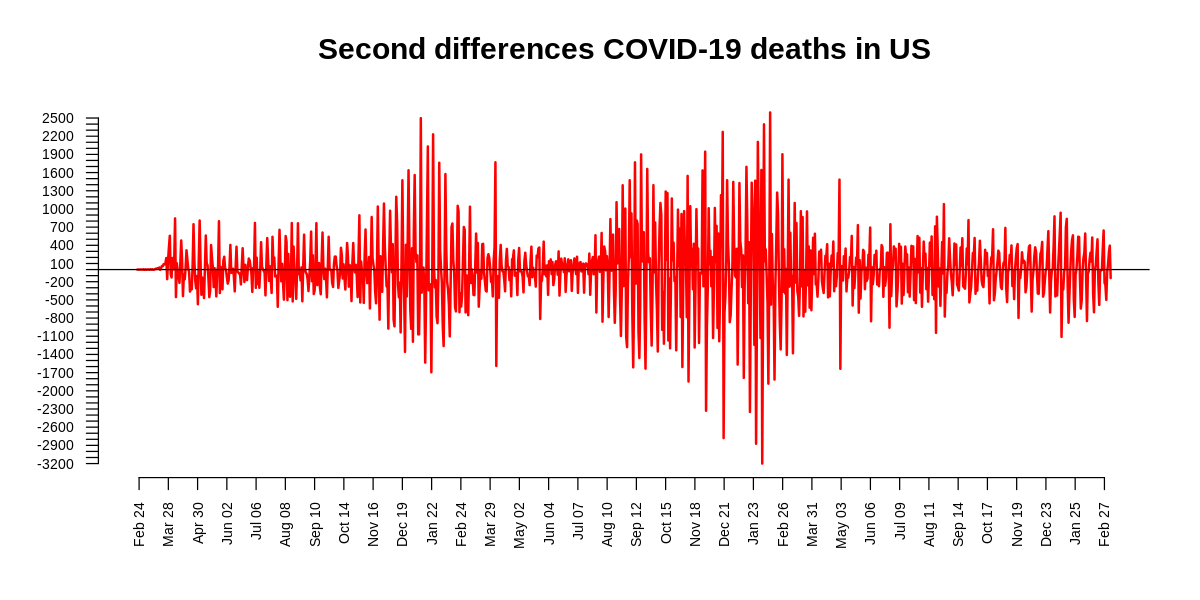

In [12]:
options(repr.plot.width=10, repr.plot.height=5)


first.der.US.deaths<-diff(ccwd$US, lag = 1, differences = 1)
sec.der.US.deaths <- diff(ccwd$US, lag = 1, differences = 2)

plot(ccwd$date[2:length(ccwd$date)-2], sec.der.US.deaths, 
     type="l", lwd=2, lty=1,
     ylab='', 
     xlab='',
     main ='Second differences COVID-19 deaths in US',
     col="red",
     axes=FALSE,
     cex.main=1.5)
abline(h=0)
at1 <- seq(min(ccwd$date)+2, max(ccwd$date), by=0.03 * (max(ccwd$date) - min(ccwd$date)));
axis.Date(1, at=at1, format="%b %d", las=2, cex.axis=0.7)
axis(side=2, seq(min(sec.der.US.deaths),max(sec.der.US.deaths),100), las=2, cex.axis=0.7)

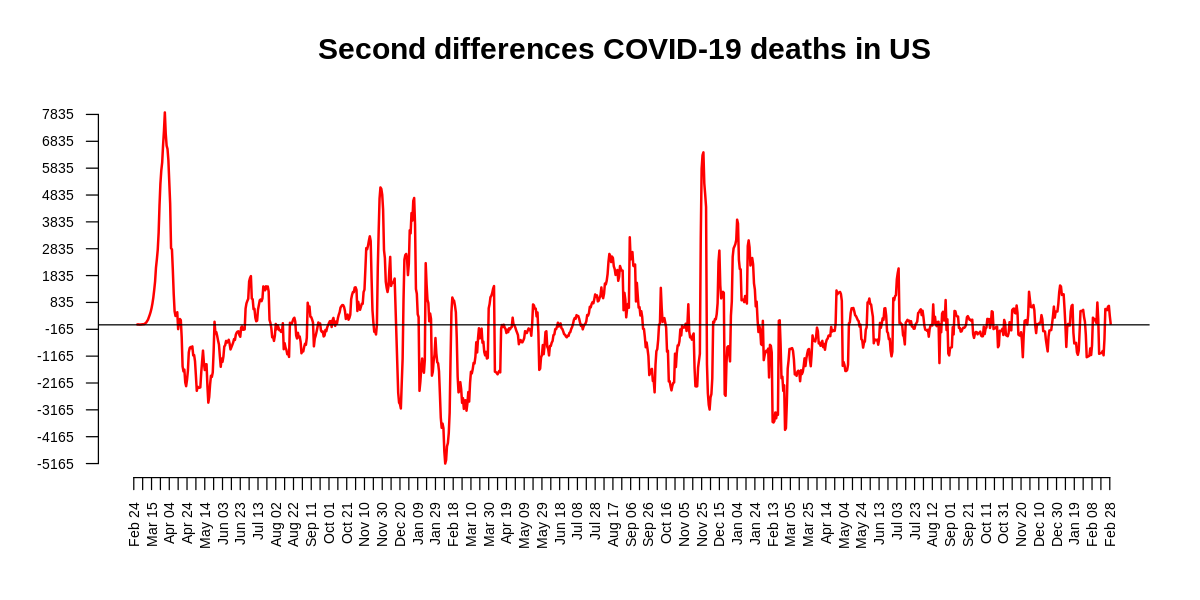

In [13]:
# Trying to get rid of day-to-day noise by sampling every 7 days:
Lag  = 7
Diff = 2
L = length(ccwd$US) - Diff * Lag

sec.der.US.deaths <- diff(ccwd$US, lag = Lag, differences = 2)

plot(ccwd$date[Lag:(Lag + (L-1))], sec.der.US.deaths, 
     type="l", lwd=2, lty=1,
     ylab='', 
     xlab='',
     main ='Second differences COVID-19 deaths in US',
     col="red",
     axes=FALSE,
     cex.main=1.5)
abline(h=0)
at1 <- seq(min(ccwd$date)+2, max(ccwd$date), by=10);
axis.Date(1, at=at1, format="%b %d", las=2, cex.axis=0.7)
axis(side=2, seq(min(sec.der.US.deaths),max(sec.der.US.deaths),1000), 
     las=2, cex.axis=0.7)

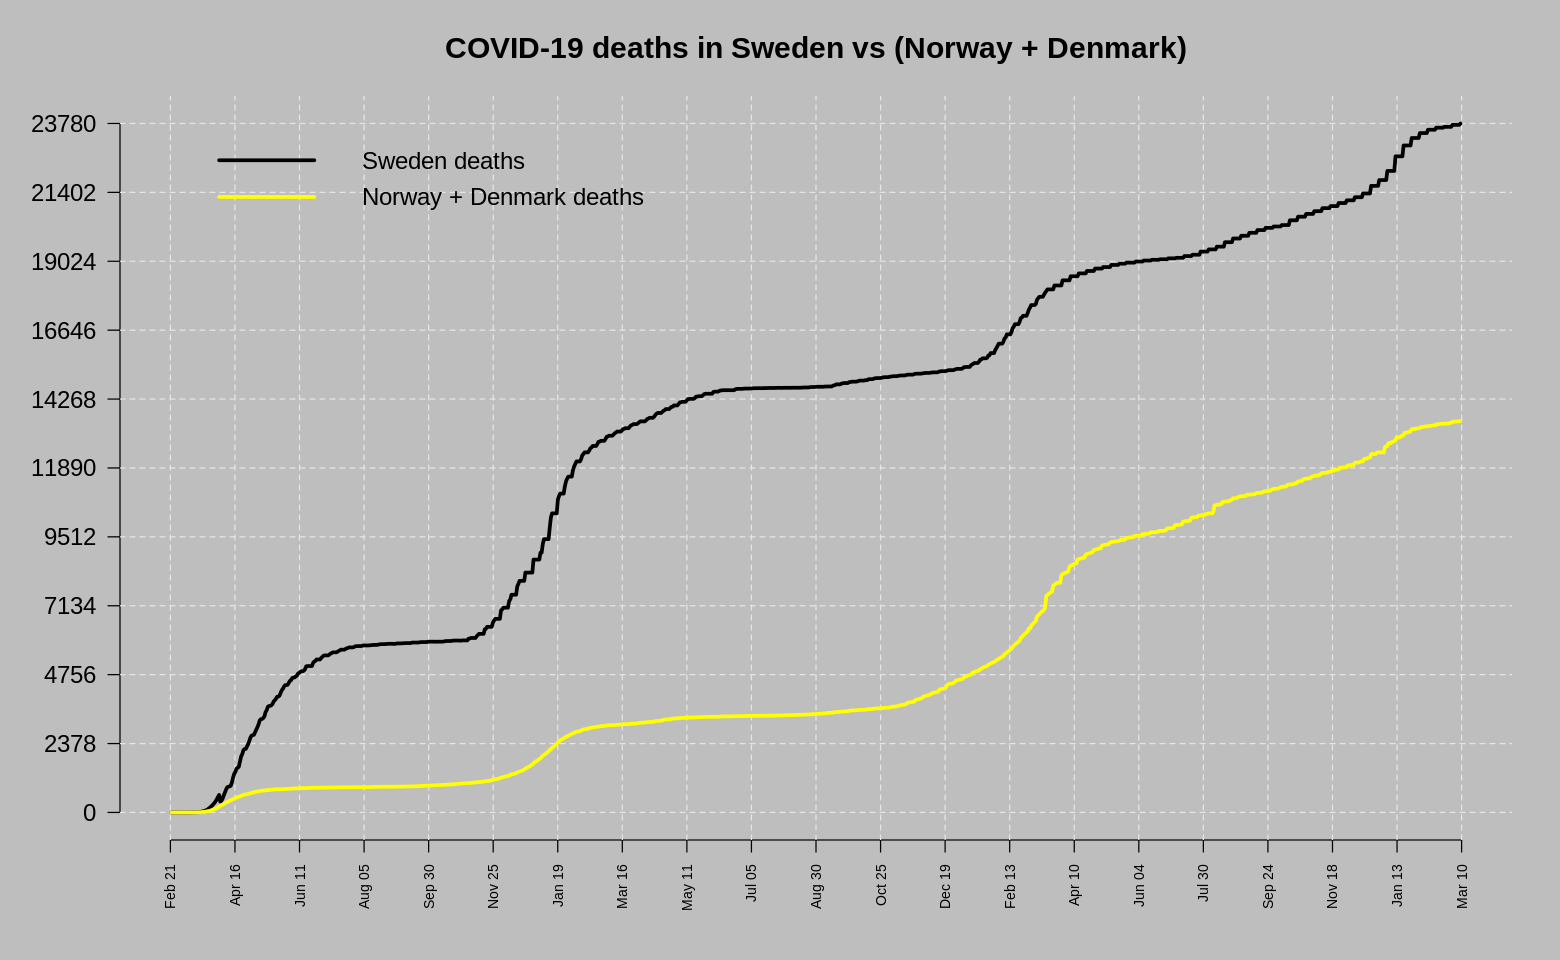

In [14]:
# cumulative number of deaths in Sweden compared to Norway + DenmarK:

combo <- ccwd$Norway + ccwd$Denmark
Swe <- ccwd$Sweden
scand <- as.data.frame(cbind(Swe,combo))
Y <- ifelse(tail(Swe,1) > tail(combo,1), 1, 2)

options(repr.plot.width=13, repr.plot.height=8)
par(mar=c(5,5,4,2))
par(bg = 'gray')

plot(ccwd$date, scand[,Y], 
      type="n", lwd=3, lty=1,
      ylab='', 
      xlab='',
      main ='COVID-19 deaths in Sweden vs (Norway + Denmark)',
      axes=FALSE,
      cex.main=1.5)


at1 <- seq(min(ccw$date), max(ccw$date)+5, by=0.05*length(ccw$date))
axis.Date(1, at=at1, format="%b %d", las=2, cex.axis=0.7)
 
at2 <- seq(0,max(scand[,Y])+.1*max(scand[,Y]),by=round(.1*max(scand[,Y])))
axis(side=2, at2, cex.axis=1.2, las=1)

abline(h=at2, lty=2, col="grey90")  # Add faint grid lines
abline(v=at1, lty=2, col="grey90")  # Add faint grid lines

lines(ccwd$date, ccwd$Sweden, lwd=3, col=1)
lines(ccwd$date, ccwd$Norway + ccwd$Denmark, lwd=3, col="yellow")

legend(ccwd$date[1], max(scand[,Y]), bg="transparent",
       legend=c("Sweden deaths", "Norway + Denmark deaths"),
       col=c(1, 'yellow'), lty=c(1,1), lwd=3, cex=1.2,
       box.lty=0)

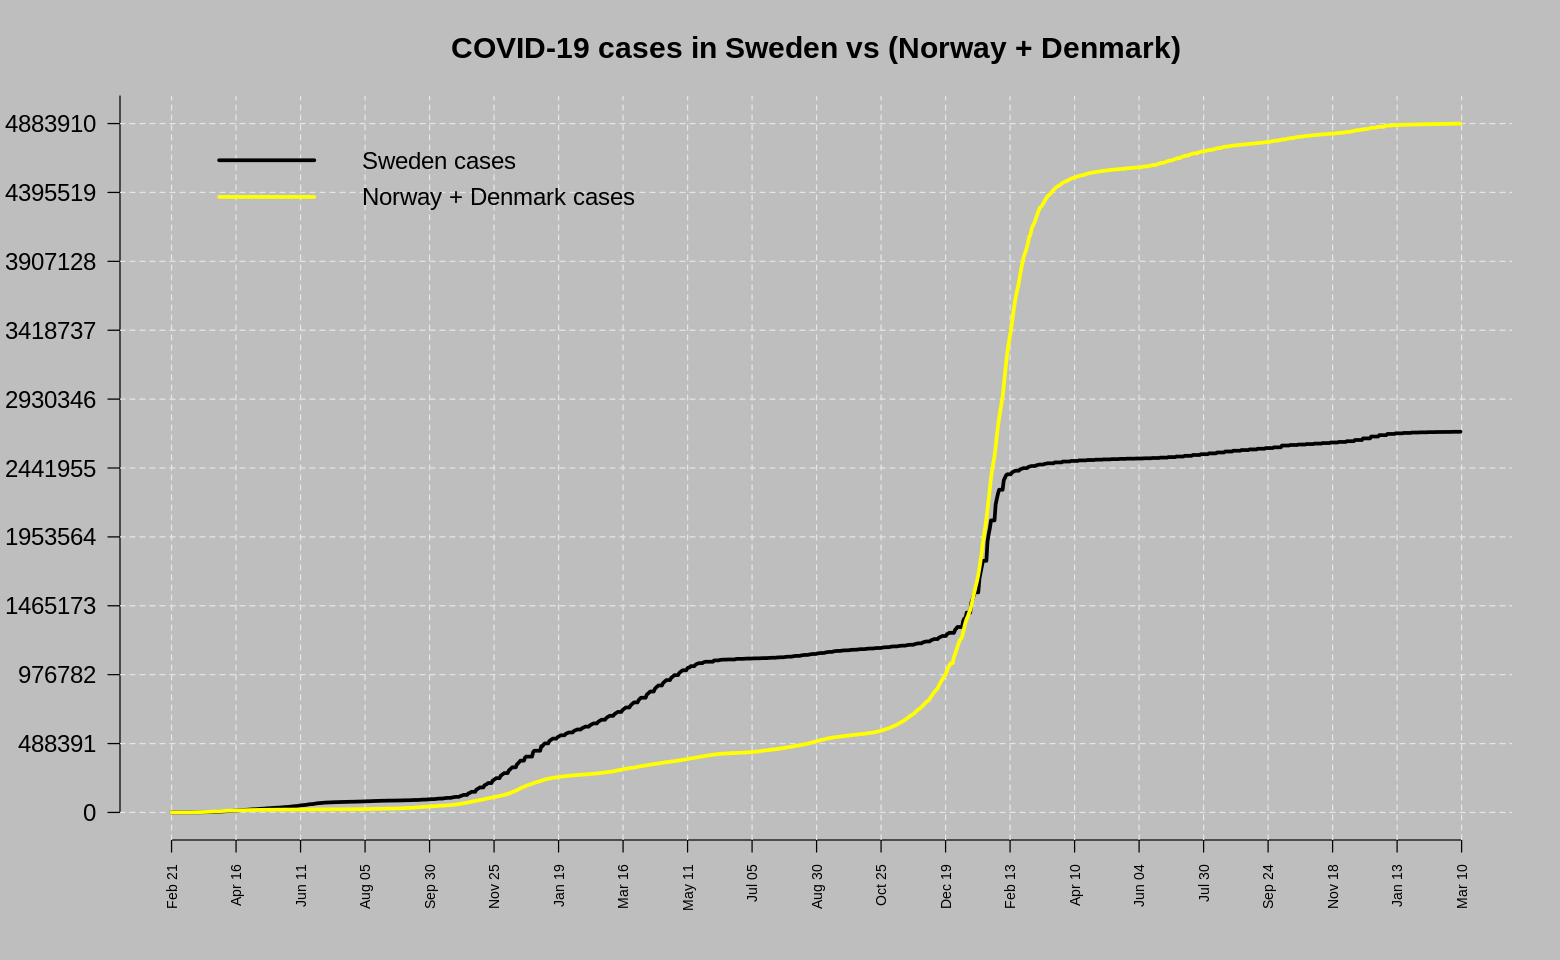

In [15]:
# Comparison in the number of cases in Sweden versus Norway + Denmark:

combocases <- ccw$Norway + ccw$Denmark
Swecases <- ccw$Sweden
scandcases <- as.data.frame(cbind(Swecases,combocases))
Ycases <- ifelse(tail(Swecases,1) > tail(combocases,1), 1, 2)

options(repr.plot.width=13, repr.plot.height=8)
par(mar=c(5,5,4,2))
par(bg = 'gray')

plot(ccw$date, scandcases[,Ycases], 
      type="n", 
      ylab='', 
      xlab='',
      main ='COVID-19 cases in Sweden vs (Norway + Denmark)',
      axes=FALSE,
      cex.main=1.5)

at1 <- seq(min(ccw$date), max(ccw$date)+5, by=0.05*length(ccw$date))
axis.Date(1, at=at1, format="%b %d", las=2, cex.axis=0.7)
 
at2 <- seq(0, max(scandcases[,Ycases]) + .1*max(scandcases[,Ycases]), by=round(.1*max(scandcases[,Ycases])))
axis(side=2, at2, cex.axis=1.2, las=1)

abline(h=at2, lty=2, col="grey90")  # Add faint grid lines
abline(v=at1, lty=2, col="grey90")  # Add faint grid lines

lines(ccw$date, ccw$Sweden, lwd=3, col=1)
lines(ccw$date, ccw$Norway + ccw$Denmark, lwd=3, col='yellow')

legend(ccw$date[1], max(scandcases[,Ycases]), bg="transparent",
       legend=c("Sweden cases", "Norway + Denmark cases"),
       col=c(1, 'yellow'), lty=c(1,1), lwd=3, cex=1.2,
       box.lty=0)

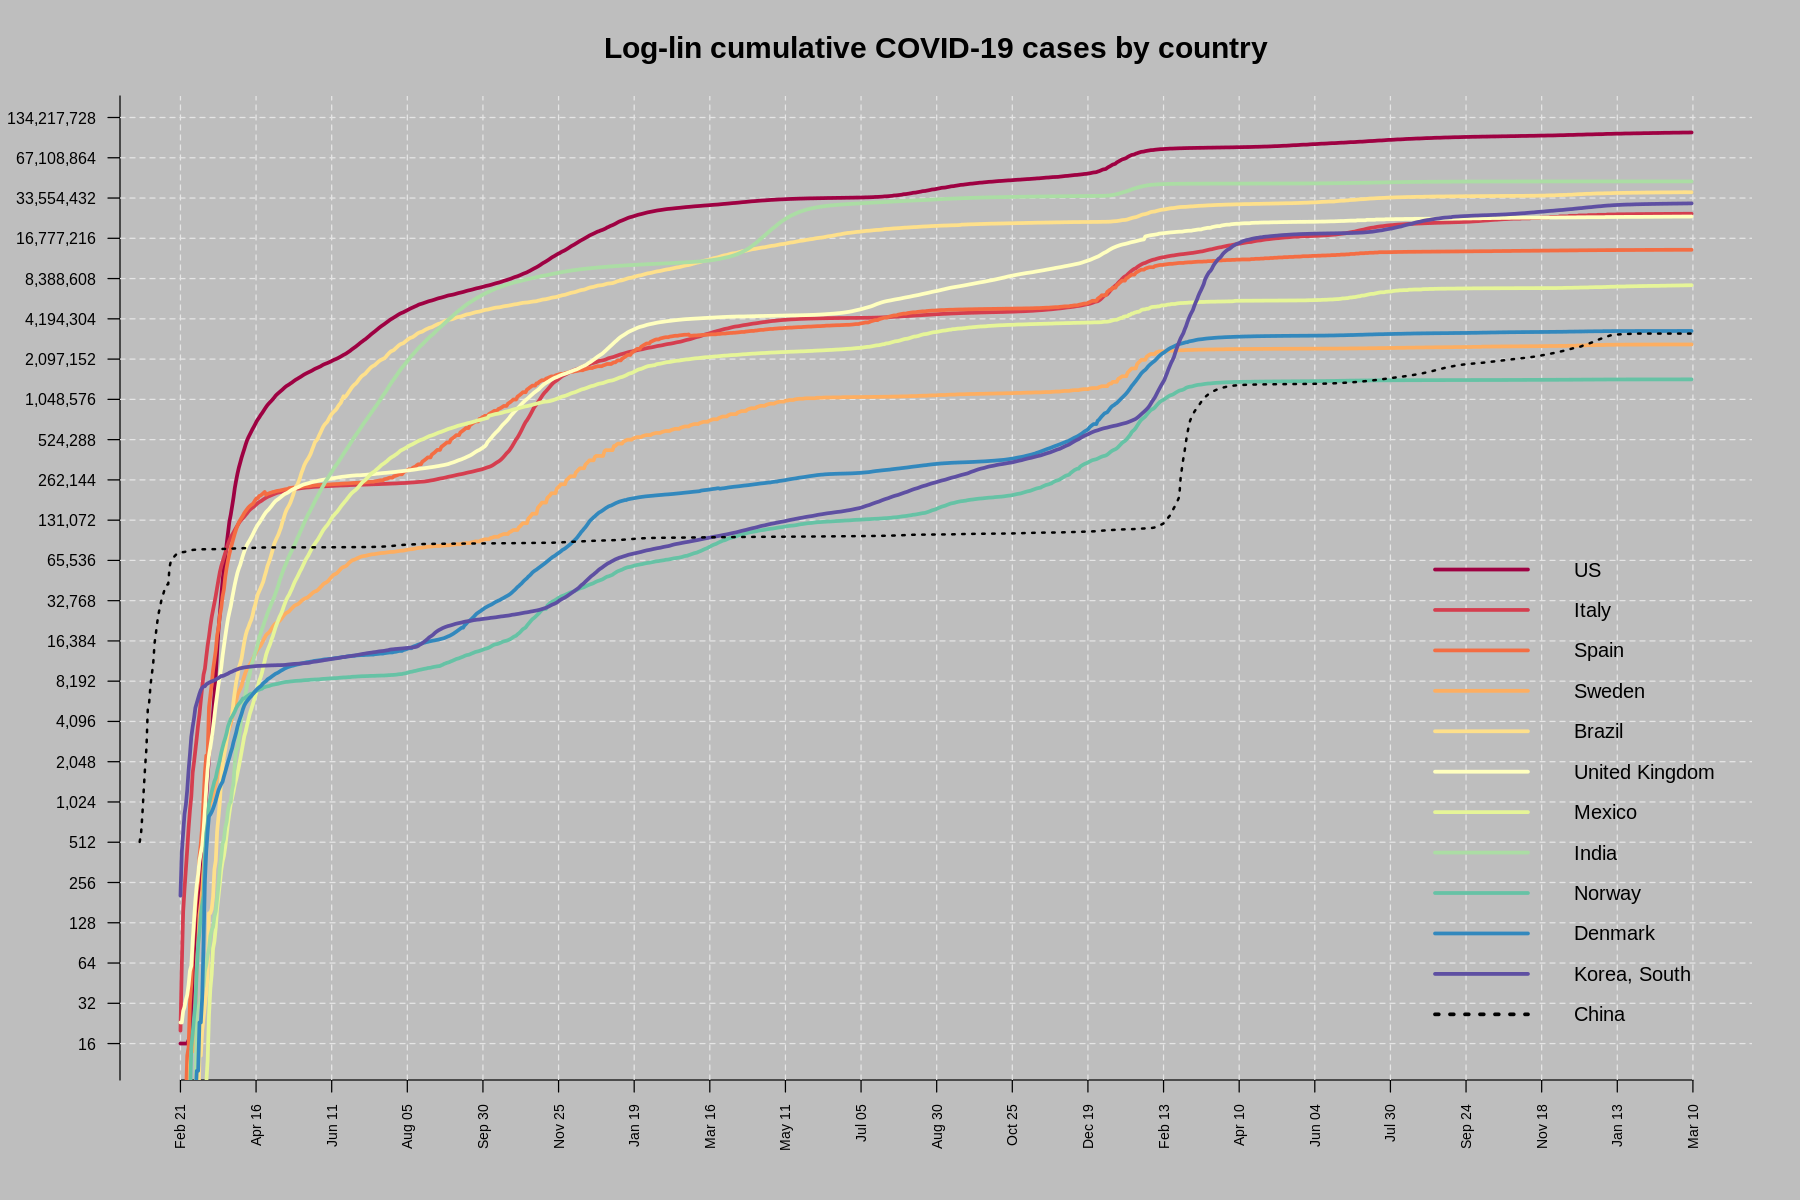

In [16]:
# Log-lin plot of cumulative number of cases by country:

options(repr.plot.width=15, repr.plot.height=10)
par(mar=c(5,5,4,2))
par(bg = 'gray')

no.one <- names(ccw[,-c(1,2)])[which.max(tail(ccw[,-c(1,2)],1))]

plot(ccw$date, pull(ccw[,no.one]), type="n", lwd=4, 
     ylab='', 
     xlab='',
     log='y',
     col=co[1],
     axes=FALSE,
     main = "Log-lin cumulative COVID-19 cases by country",
     cex.main=1.5)

at1 <- seq(min(ccw$date), max(ccw$date)+5, by=0.05*length(ccw$date))
axis.Date(1, at=at1, format="%b %d", las=2, cex.axis=0.7)

at2 <- 2^seq(1, 1.1 * log2(max(pull(ccw[,no.one]))), by= round(.05 * log2(max(pull(ccw[,no.one])))))
axis(side=2, at2, cex.axis=0.8, las=2, labels = formatC(at2, big.mark = ",", format = "d"))

abline(h=at2, lty=2, col="grey90")  # Add faint grid lines
abline(v=at1, lty=2, col="grey90")  # Add faint grid lines

for(i in 1:length(countries)) lines(ccw$date, pull(ccw[,countries[i]]), lwd=3, col=co[i])

lines(ccw_china$date, ccw_china$China,  lwd=2, lty=3)

legend(ccw$date[round(0.8*length(ccw$date))], 0.1*max(pull(ccwd[,no.one])), bg="transparent",
       legend=c(countries, "China"),
       col = c(co[1:(length(countries))],"black"), lty=c(rep(1,length(countries)),3), lwd=3, cex=1,
       box.lty=0)

[1] "Total cases in the USA:  103,802,702 out of 328,000,000 or  31.65  percent."

[1] "Total cases in the India:  44,690,738 out of 1,353,000,000 or  3.3  percent."

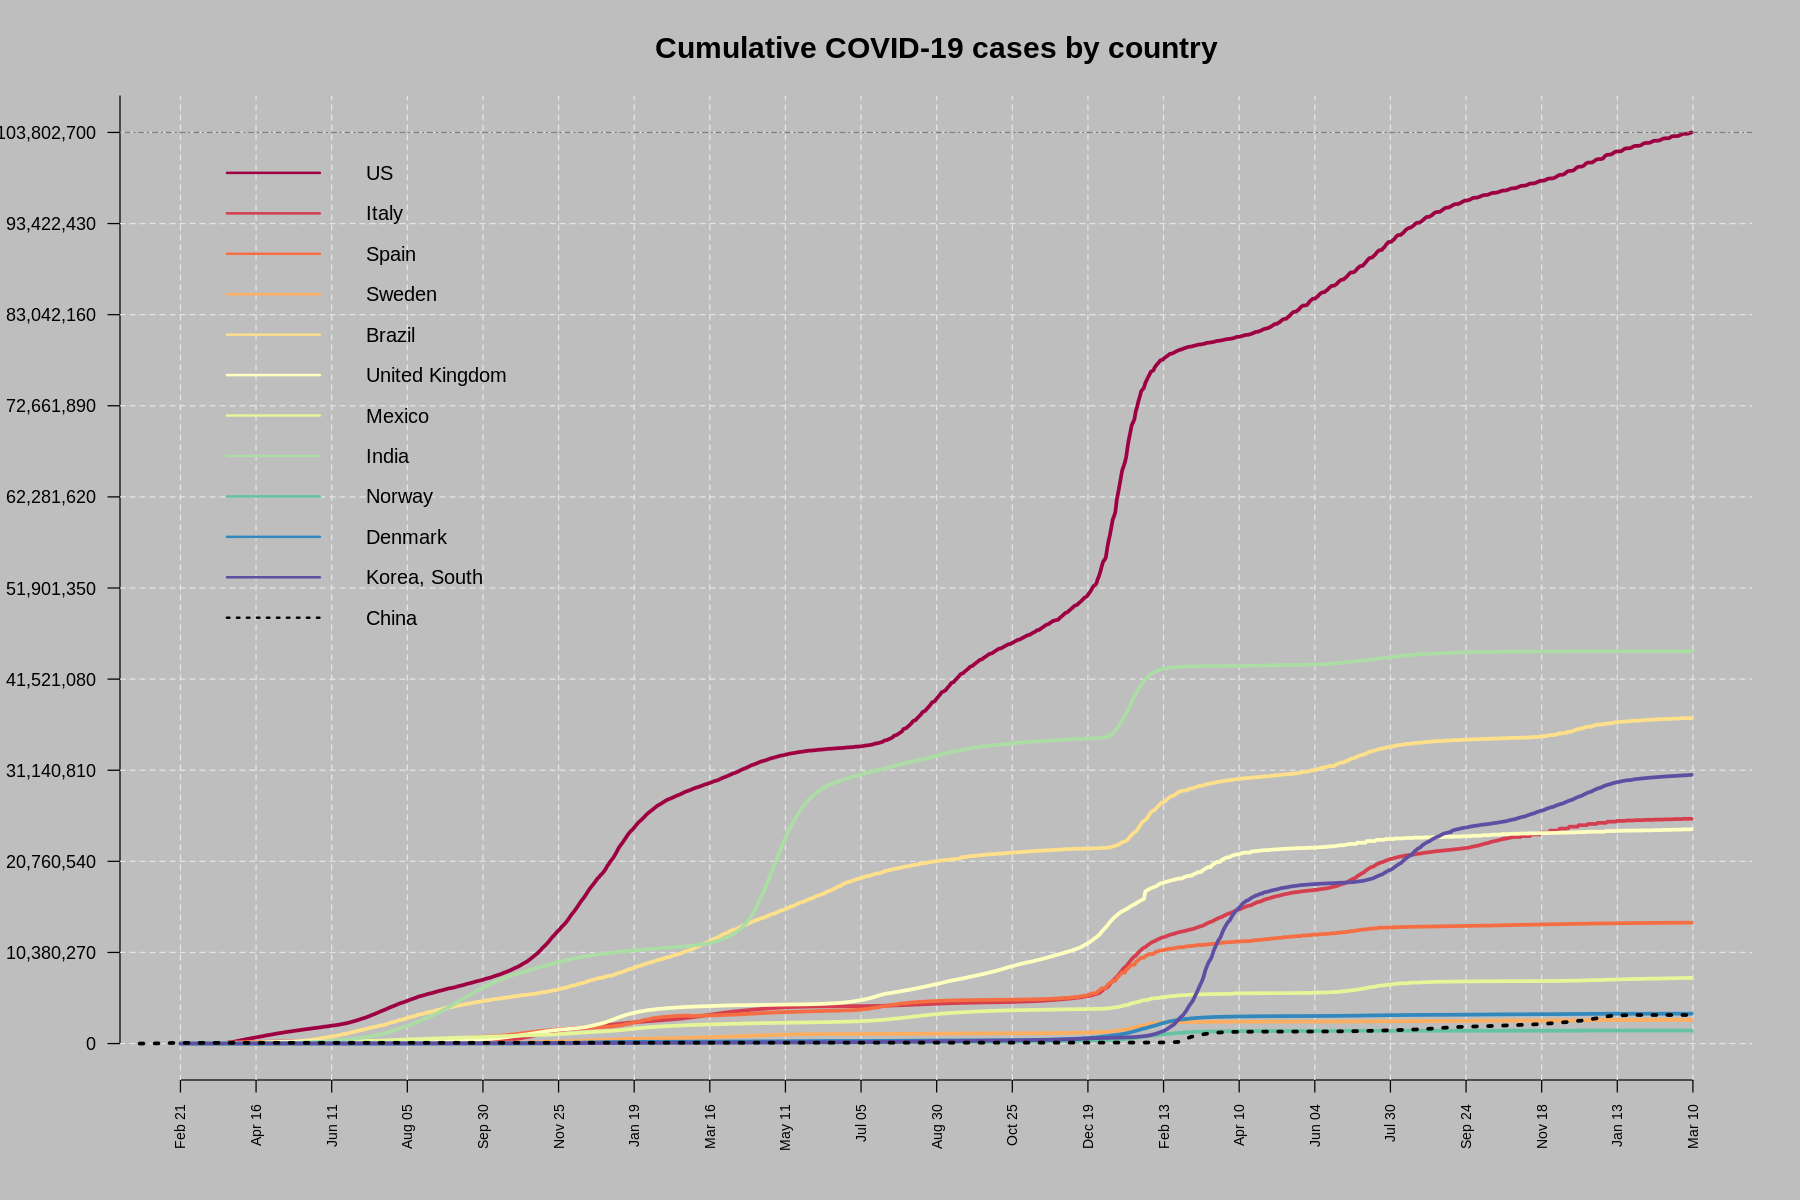

In [17]:
# cumulative number of cases by country:

par(mar=c(5,5,4,2))
par(bg = 'gray')

plot(ccw$date, pull(ccw[,no.one]), type="no", 
     ylab='', 
     xlab='',
     axes=F,
     main = "Cumulative COVID-19 cases by country",
     cex.main=1.5)

at1 <- seq(min(ccw$date), max(ccw$date)+5, by=0.05*length(ccw$date))
axis.Date(1, at=at1, format="%b %d", las=2, cex.axis=0.7)

at2 <- seq(0, max(pull(ccw[,no.one])) + 0.1 * max(pull(ccw[,no.one])), by=round(0.1*max(pull(ccw[,no.one]))))
axis(side=2, at2, labels = formatC(at2, big.mark = ",", format = "d"), cex.axis=0.9, las=1)


abline(v=at1, lty=2, col="grey90")  # Add faint grid lines
abline(h=at2, lty=2, col="grey90")  # Add faint grid lines

for(i in 1:length(countries)) lines(ccw$date, pull(ccw[,countries[i]]), lwd=3, col=co[i])
lines(ccw_china$date, ccw_china$China,  lwd=3, lty=3)

legend(ccw$date[1], max(pull(ccw[,no.one])), bg="transparent",
       legend=c(countries,"China"),
       col=c(co[1:length(countries)], "black"), lty=c(rep(1,length(countries)), 3), lwd=2, cex=1,
       box.lty=0)

abline(h=tail(pull(ccw[,no.one]),1), col="gray50", lty=4)

paste("Total cases in the USA: ", format(tail(ccw$US,1),format="d",big.mark=","), "out of 328,000,000 or ", 
        round(tail(ccw$US,1)*100/328000000,2), " percent.")
paste("Total cases in the India: ", format(tail(ccw$India,1),format="d",big.mark=","), "out of 1,353,000,000 or ", 
        round(tail(ccw$India,1)*100/1353000000,2), " percent.")

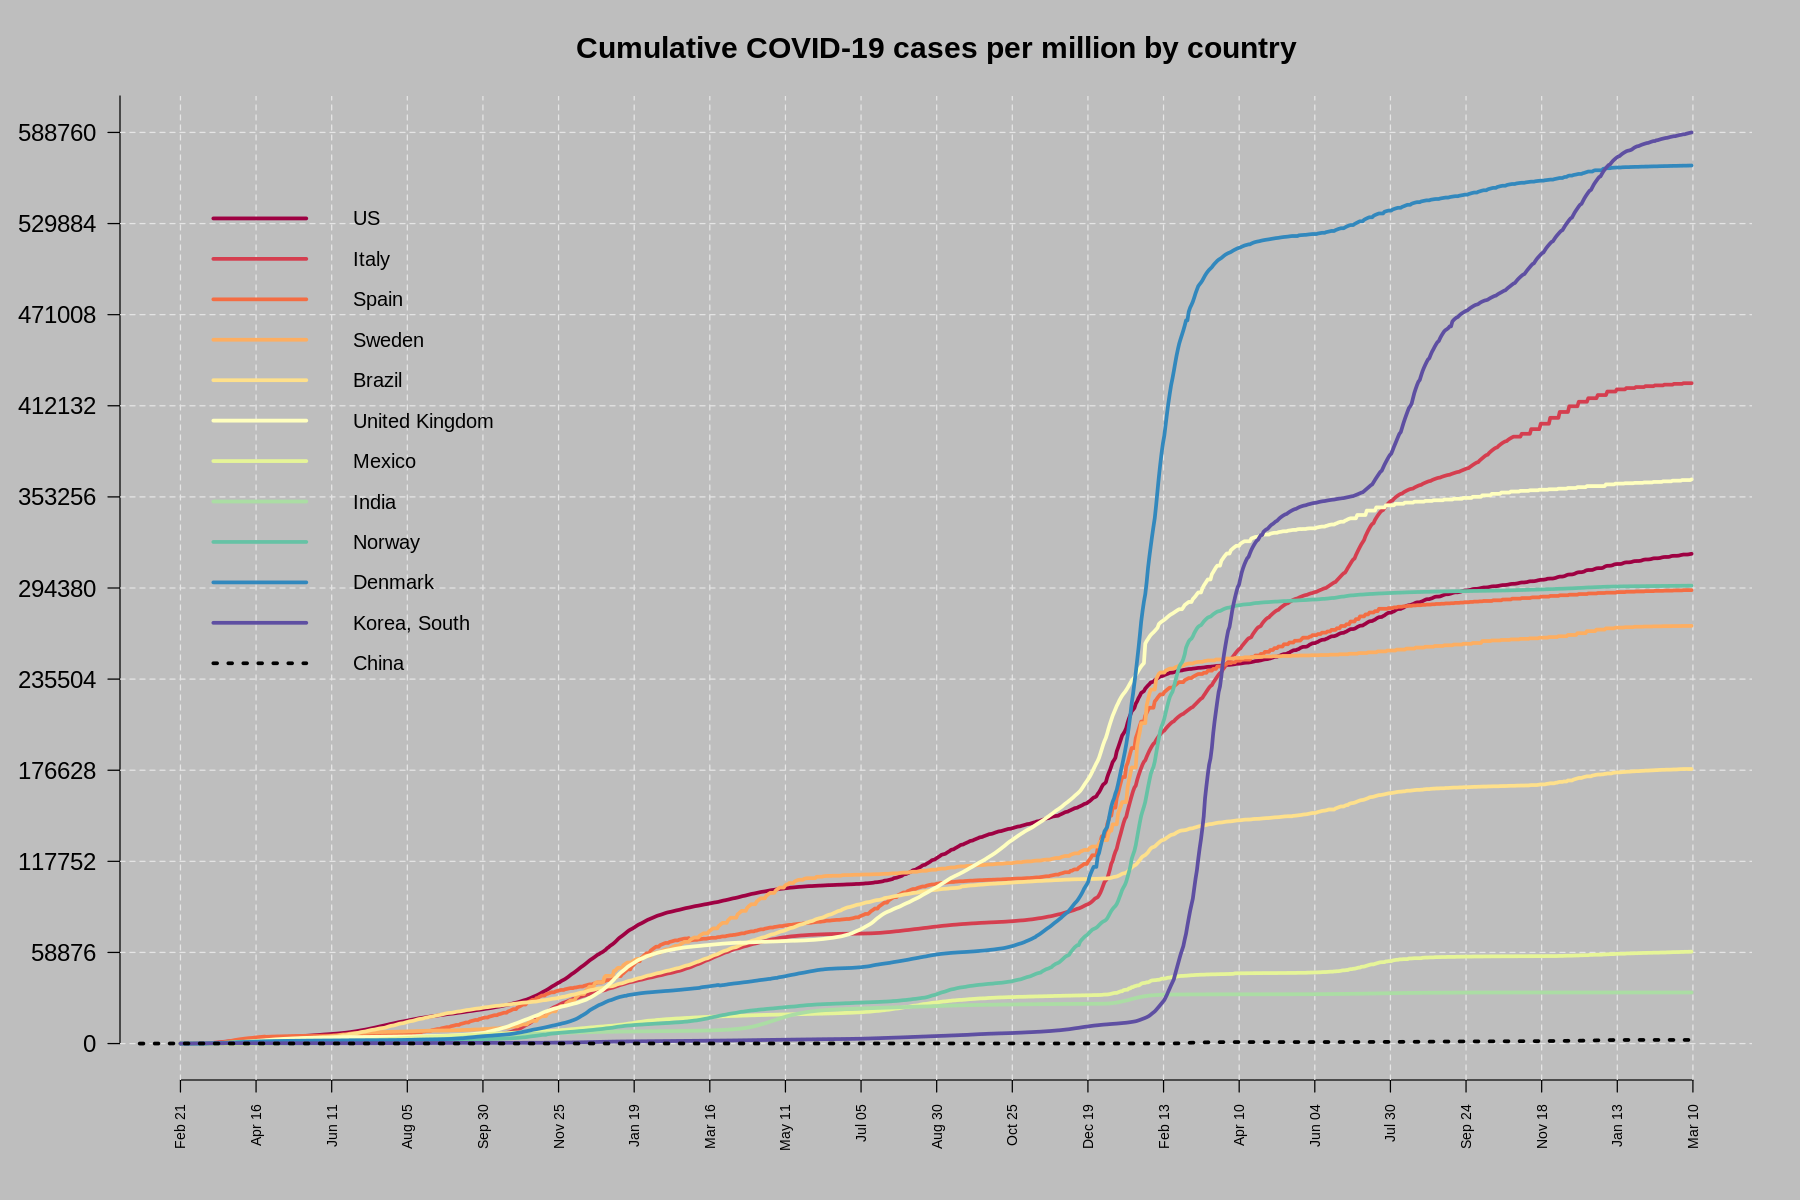

In [18]:
# cumulative number of cases per million by country:

c.ranking <- c(US=max(ccw$US/popUS), Italy=max(ccw$Italy/popItaly), Spain=max(ccw$Spain/popSpain), Sweden=max(ccw$Sweden/popSweden), 
            Brazil=max(ccw$Brazil/popBrazil), `United Kingdom`=max(ccw$`United Kingdom`/popUK), 
            Mexico=max(ccw$Mexico/popMex), India=max(ccw$India/popIndia), 
            Norway=max(ccw$Norway/popNorw), Denmark=max(ccw$Denmark/popDen),
            `Korea, South`=max(ccw$`Korea, South`/popSK))

y_axis <- pull(ccw[,names(which.max(c.ranking))])/populations[which.max(c.ranking)]

par(mar=c(5,5,4,2))
par(bg = 'gray')
plot(ccw$date, y_axis, type="n", 
     ylab='', 
     xlab='',
     axes=F,
     main = "Cumulative COVID-19 cases per million by country",
     cex.main=1.5)


at1 <- seq(min(ccw$date), max(ccw$date)+5, by=0.05*length(ccw$date))
axis.Date(1, at=at1, format="%b %d", las=2, cex.axis=0.7)

at2 <- seq(0, max(c.ranking)+.1*max(c.ranking),by=round(.1*max(c.ranking)))
axis(side=2, at2, cex.axis=1.2, las=1)
 
abline(h=at2, lty=2, col="grey90")  # Add faint grid lines
abline(v=at1, lty=2, col="grey90")  # Add faint grid lines

for(i in 1:length(countries)) lines(ccw$date, pull(ccw[,countries[i]]/populations[i]), lwd=3, col=co[i])

lines(ccw_china$date, ccw_china$China/popChina, lwd=3, lty=3)

legend(ccw$date[1] - 10, 0.95*max(c.ranking), bg="transparent",
       legend = c(countries,"China"),
       col = c(co[1:(length(countries))],"black"), 
       lty=c(rep(1,length(countries)),3), 
       lwd=3, cex=1,
       box.lty=0)

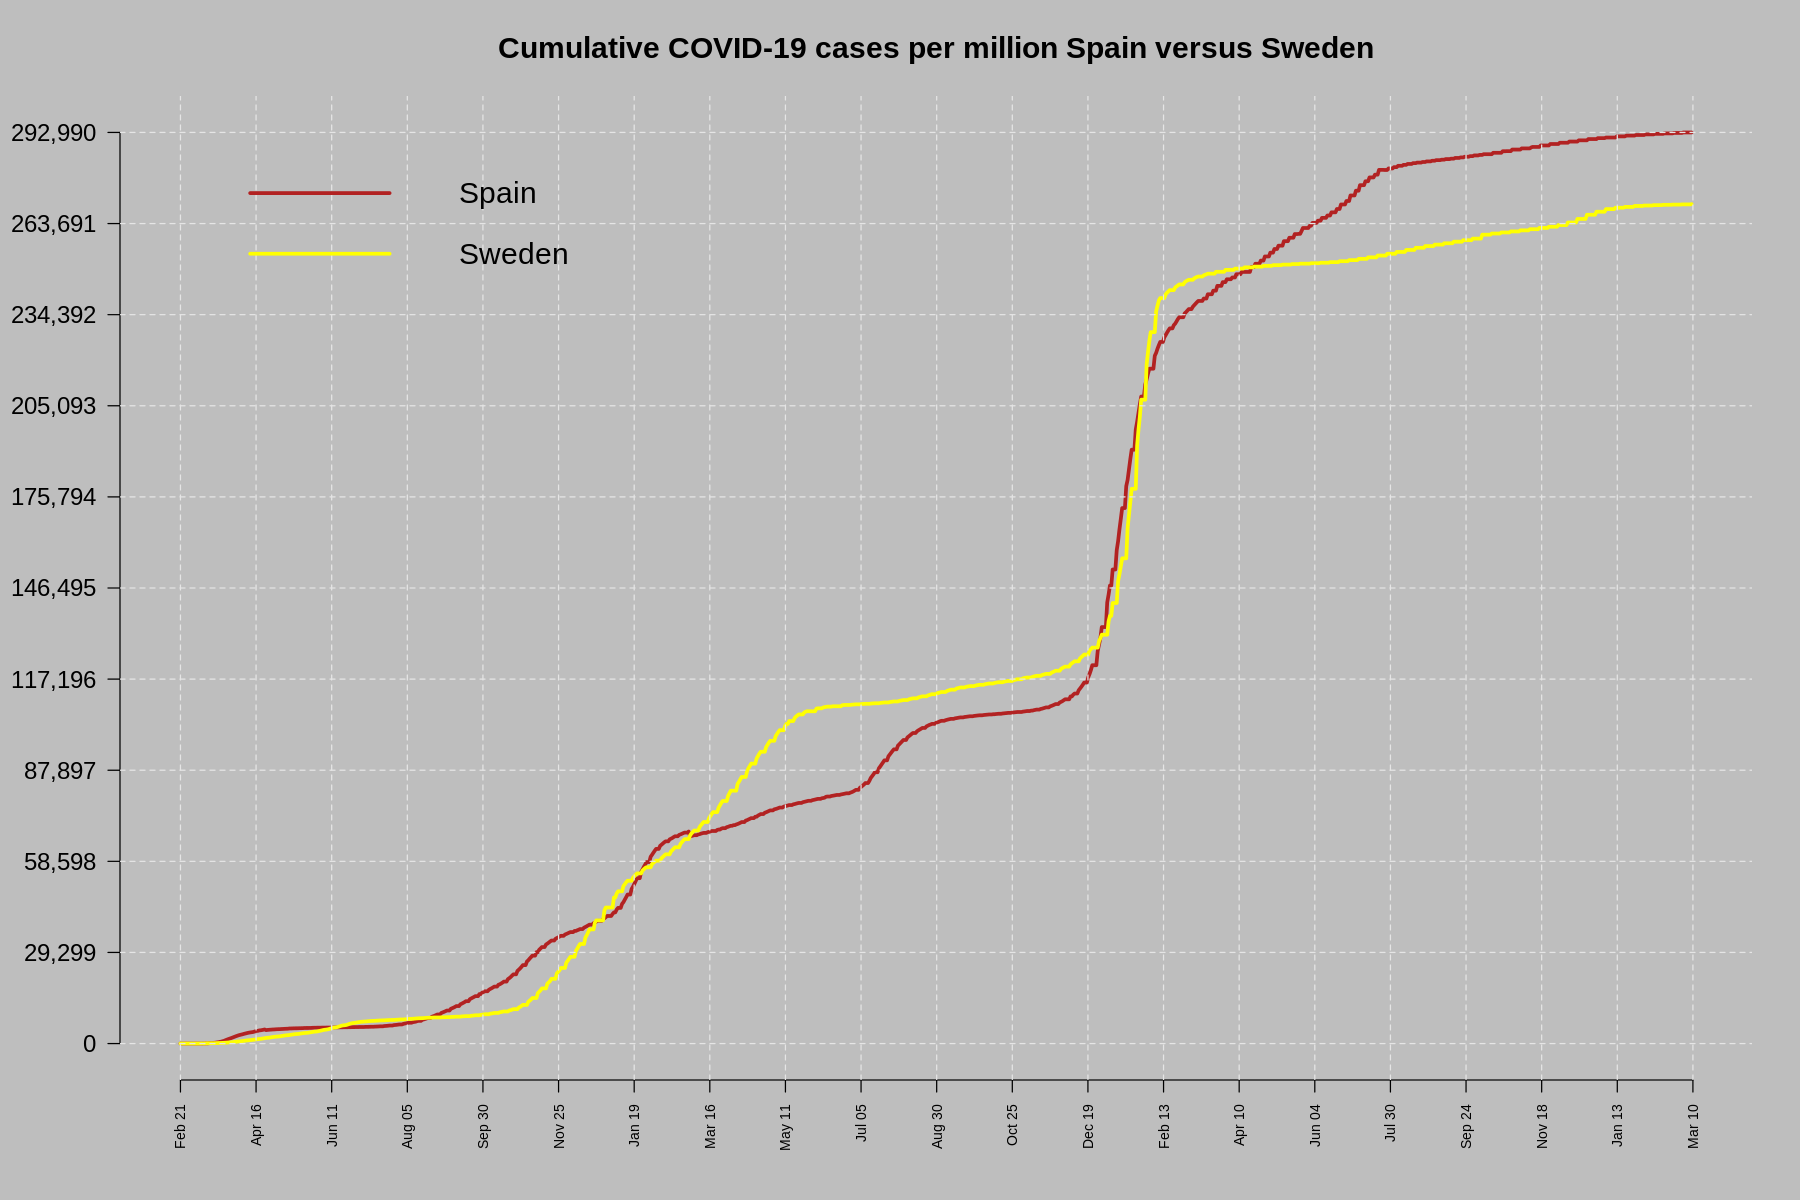

In [19]:
par(mar=c(5,5,4,2))
par(bg = 'gray')

ranks <- c(Spain=max(ccw$Spain/popSpain), Sweden=max(ccw$Sweden/popSweden))

population <- c(popSpain, popSweden)

y.axis <- pull(ccw[,names(which.max(ranks))])/population[which.max(ranks)]

plot(ccw$date, y.axis, type="l", lwd=3, lty=1,
     ylab='', 
     xlab='',
     col="firebrick",
     axes=F,
     cex.axis=1,
     las=2,
     main = "Cumulative COVID-19 cases per million Spain versus Sweden",
     cex.main=1.5,
     bty='l')
 
at1 <- seq(min(ccw$date), max(ccw$date)+5, by=0.05*length(ccw$date))
axis.Date(1, at=at1, format="%b %d", las=2, cex.axis=0.7)
 
at2 <- seq(0, max(y.axis+.1 * max(y.axis)), by=round(.1 * max(y.axis)))
axis(side=2, at2, cex.axis=1.2, las=2, labels = formatC(at2, big.mark = ",", format = "d"))
 
lines(ccw$date, pull(ccw[,names(which.min(ranks))])/population[which.min(ranks)], lwd=3, col="yellow")

abline(v=at1, lty=2, col="grey90")  # Add faint grid lines
abline(h=at2, lty=2, col="grey90")  # Add faint grid lines
 
legend(ccw$date[1], max(ccw$Spain/popSpain), bg="transparent",
       legend=c("Spain", "Sweden"),
       col=c("firebrick","yellow"), lwd=3, cex=1.5,
       box.lty=0)

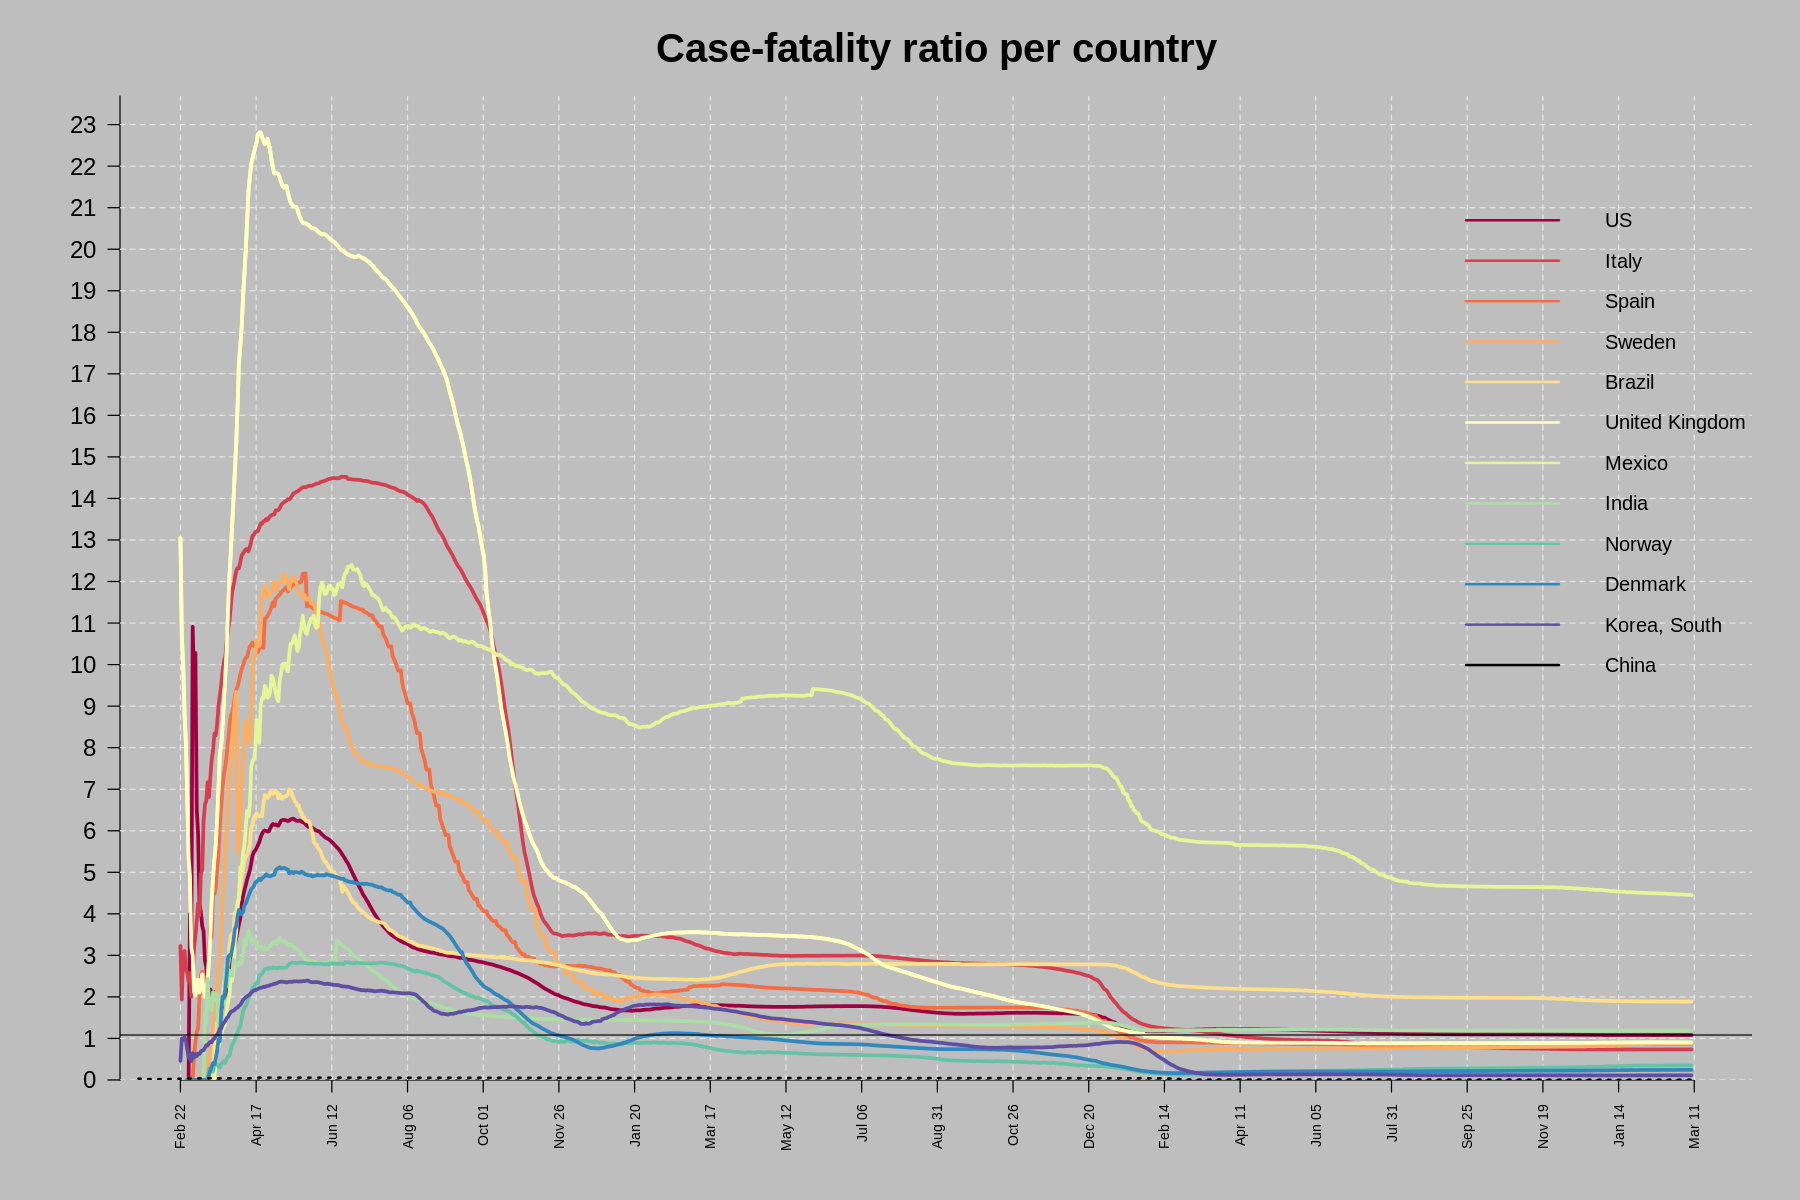

In [20]:
# Number of deaths either per 100 confirmed cases (observed case-fatality ratio):
par(mar=c(5,5,4,2))
par(bg = 'gray')


plot(ccwd$date, ccwd$`United Kingdom`/ccw$`United Kingdom`[2:length(ccw$`United Kingdom`)] * 100, type="l", lwd=3, lty=1,
     xlab='',
     ylab='',
     main ='Case-fatality ratio per country',
     axes = FALSE,
     col=co[6],
     cex.main=2)

at1 <- seq(min(ccwd$date), max(ccwd$date)+5, by=0.05*length(ccw$date))
axis.Date(1, at=at1, format="%b %d", las=2, cex.axis=0.7)

max.ratio <- max(ccwd$`United Kingdom`/ccw$`United Kingdom`[2:length(ccw$`United Kingdom`)] * 100)

at2 <- seq(0, max.ratio + 5, by=round(.05 * max.ratio))
axis(side=2, at2, cex.axis=1.2, las=2, labels = formatC(at2, big.mark = ",", format = "d"))

abline(v=at1, lty=2, col="grey90")  # Add faint grid lines
abline(h=at2, lty=2, col="grey90")  # Add faint grid lines

for(i in 1:length(countries)) lines(ccwd$date, pull(ccwd[,countries[i]]) / pull(ccw[,countries[i]])[2:(length(pull(ccw[,countries[i]])))] *100, lwd=3, col=co[i])

lines(ccchina$date, ccchina$cases / ccw_china$China, lty=3, lwd=2)

legend(ccwd$date[length(ccwd$date)]-200, 
        0.95*max(ccwd$`United Kingdom`/ccw$`United Kingdom`[2:length(ccw$`United Kingdom`)] * 100), bg="transparent",
        legend=c(countries, "China"),
        col = c(co[1:(length(countries))],"black"), lwd=2,
        box.lty=0)

abline(h = last(ccwd$US/ccw$US[2:length(ccw$US)] * 100))

[1] "The case rate per 100,000 people in the US is  9 ."

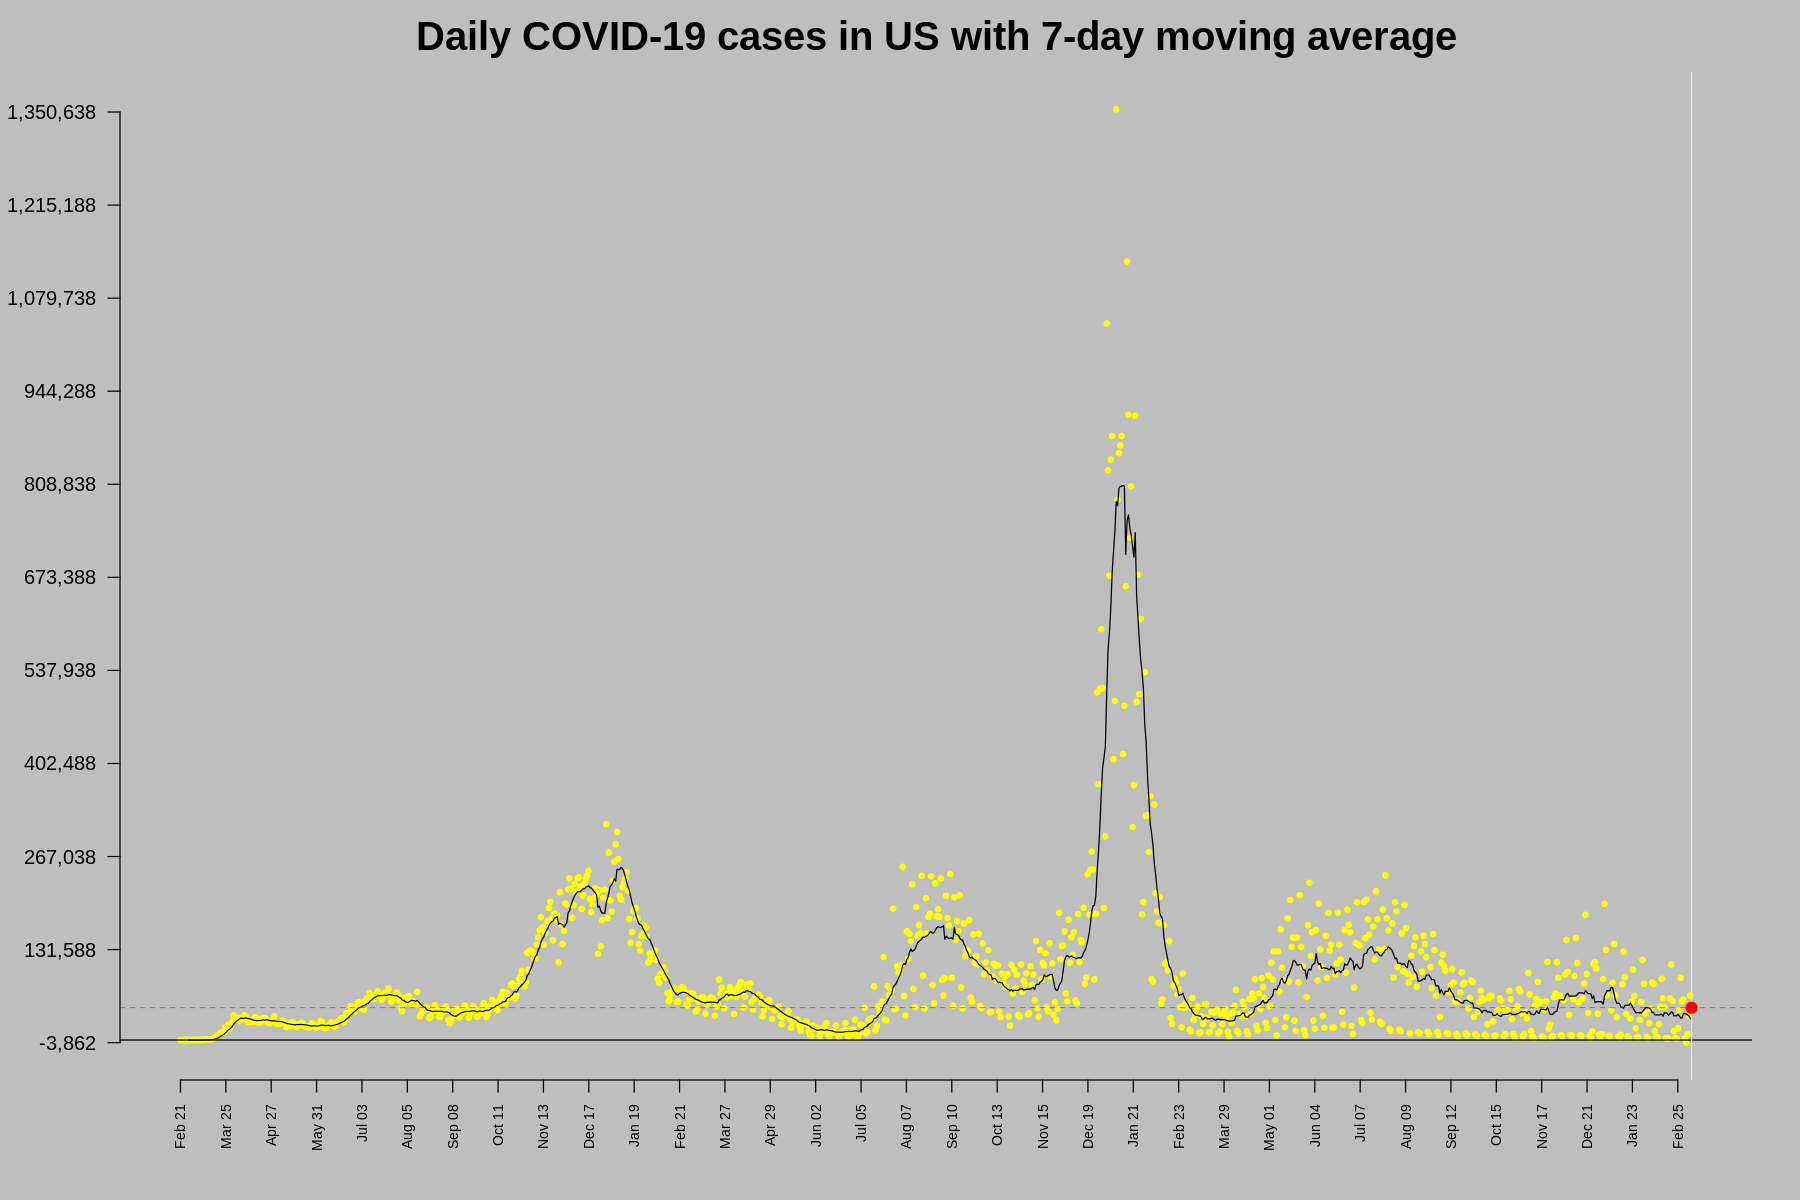

In [21]:
first.der <- diff(ccw$US, lag = 1, differences = 1)


k=7
MAV <- rollmean(first.der,k)

par(mar=c(5,5,3,2))
par(bg = 'gray')
plot(ccw$date[2:length(ccw$date)-1], first.der, 
     pch = 19, cex = .6,
     ylab='', 
     xlab='',
     main ='Daily COVID-19 cases in US with 7-day moving average',
     col='yellow',
     axes=FALSE,
     cex.main=2)


lines(ccw$date[8:length(ccw$date)-1], MAV[1:length(MAV)])
abline(h=0)
abline(v=ccw$date[length(ccw$date)-1], col='gray90')
abline(h=first.der[length(ccw$date)-1], col='firebrick', lty=2, lwd=.5)
points(ccw$date[length(ccw$date)-1], last(first.der), main="US covid-19", pch=19, cex=1.2, col='red')
at1 <- seq(min(ccw$date), max(ccw$date), by=0.03 * (max(ccw$date) - min(ccw$date)))
axis.Date(1, at=at1, format="%b %d", las=2, cex.axis=0.7)
at2 <- seq(min(first.der),max(first.der)+5000,by=round(0.1*max(first.der)))
axis(side=2, at2, 
     las=2, cex.axis=1, labels = formatC(at2, big.mark = ",", format = "d"))

popUSA = 328000000
paste("The case rate per 100,000 people in the US is ", round(last(MAV)/3280),".")

[1] "The case rate per 1,000 people in the UK is  0 ."

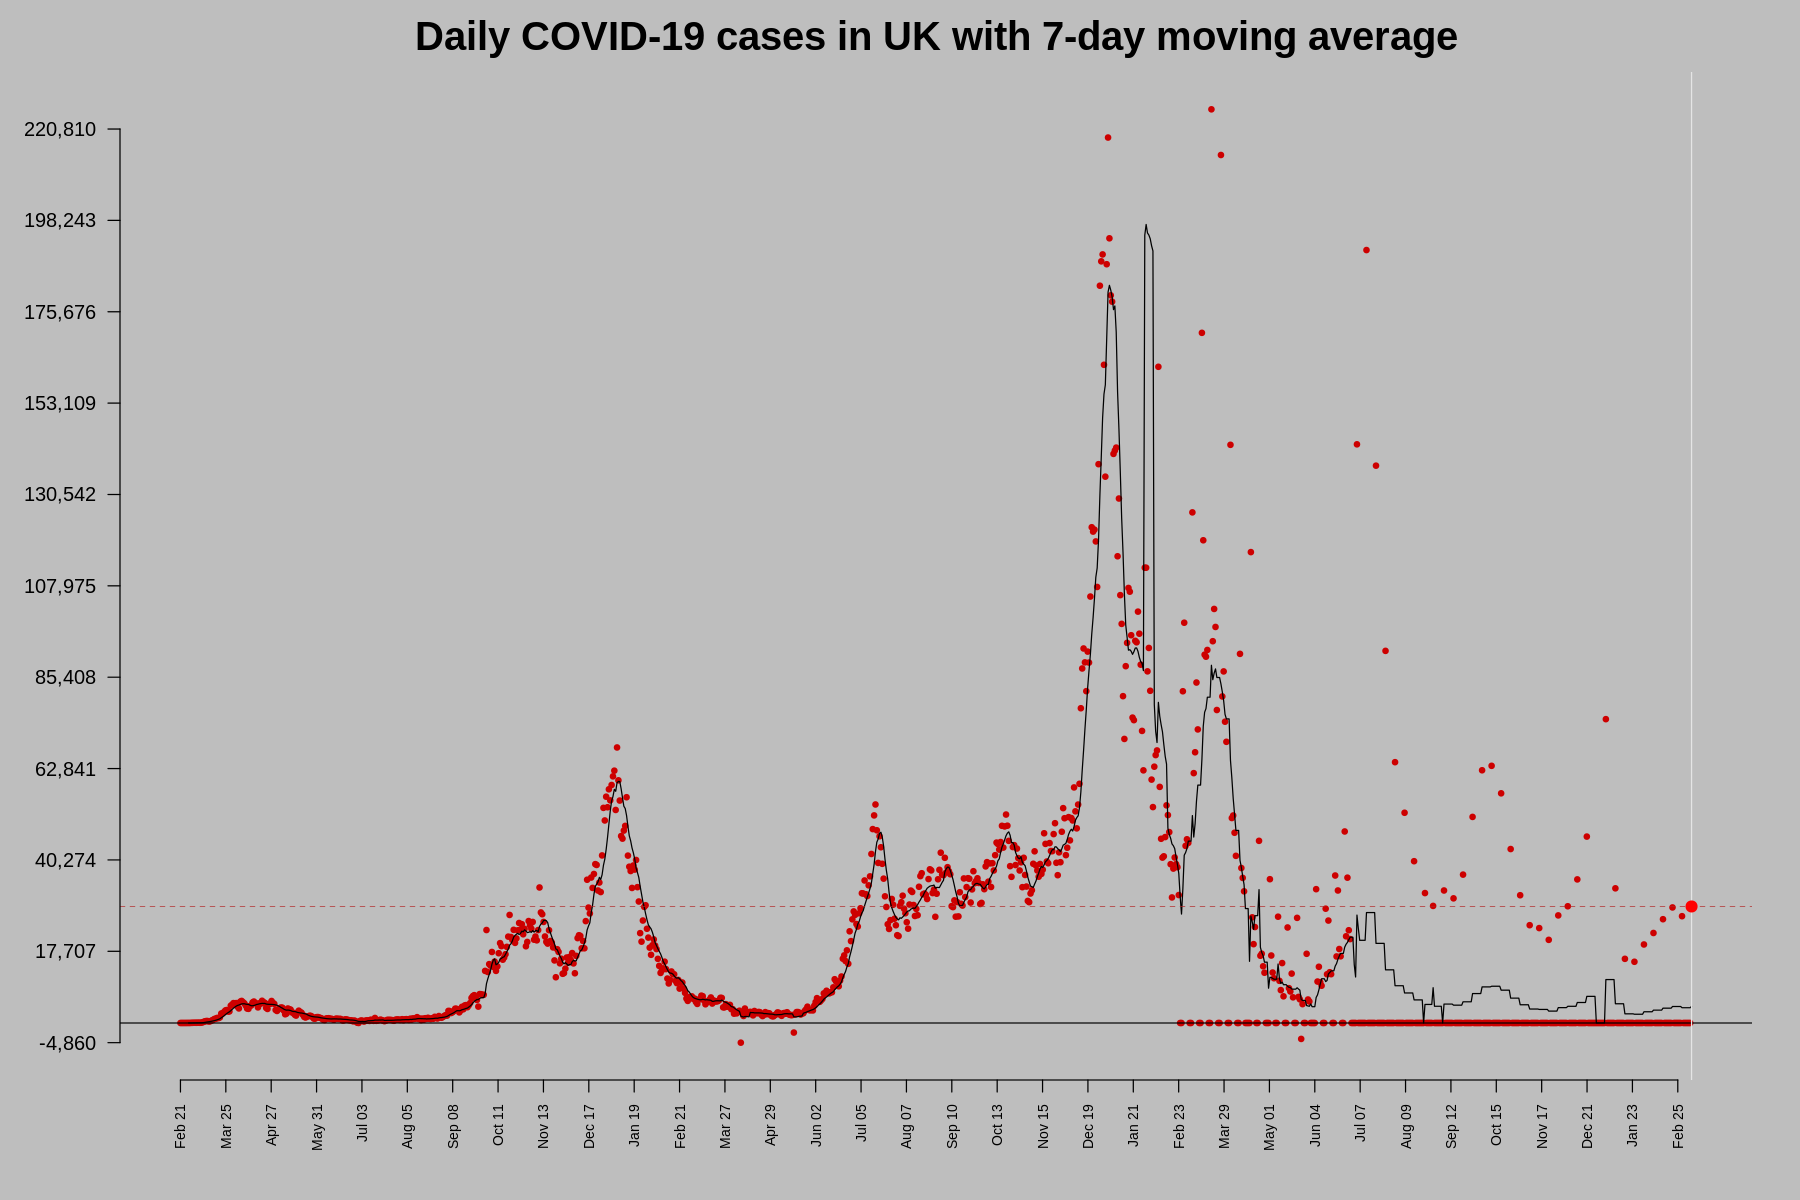

In [22]:
# What follows is the same calculation of daily values for the UK apropos of a reviewed manuscript for Skeletal Radiology:

first.der.UK <- diff(ccw$`United Kingdom`, lag = 1, differences = 1)

k=7
MAV.UK <- rollmean(first.der.UK,k)

first.der.UK[which(first.der.UK==max(first.der.UK))] <- first.der.UK[which(first.der.UK==max(first.der.UK)) + 1]

par(mar=c(5,5,3,2))
par(bg = 'gray')
plot(ccw$date[2:length(ccw$date)-1], first.der.UK, 
     pch = 19, cex = .6,
     ylab='', 
     xlab='',
     main ='Daily COVID-19 cases in UK with 7-day moving average',
     col='red3',
     axes=FALSE,
     cex.main=2)


lines(ccw$date[8:length(ccw$date)-1], MAV.UK[1:length(MAV.UK)])
abline(h=0)
abline(v=ccw$date[length(ccw$date)-1], col='gray90')
abline(h=first.der.UK[length(ccw$date)-1], col='firebrick', lty=2, lwd=.5)
points(ccw$date[length(ccw$date)-1], last(first.der.UK), main="UK covid-19", pch=19, cex=1.2, col='red')
at1 <- seq(min(ccw$date), max(ccw$date), by=0.03 * (max(ccw$date) - min(ccw$date)))
axis.Date(1, at=at1, format="%b %d", las=2, cex.axis=0.7)
at2.UK <- seq(min(first.der.UK),max(first.der.UK),by=round(0.1*max(first.der.UK)))
axis(side=2, at2.UK, 
     las=2, cex.axis=1, labels = formatC(at2.UK, big.mark = ",", format = "d"))

popUK = 66600000
paste("The case rate per 1,000 people in the UK is ", round(last(MAV.UK)/popUK*1000),".")

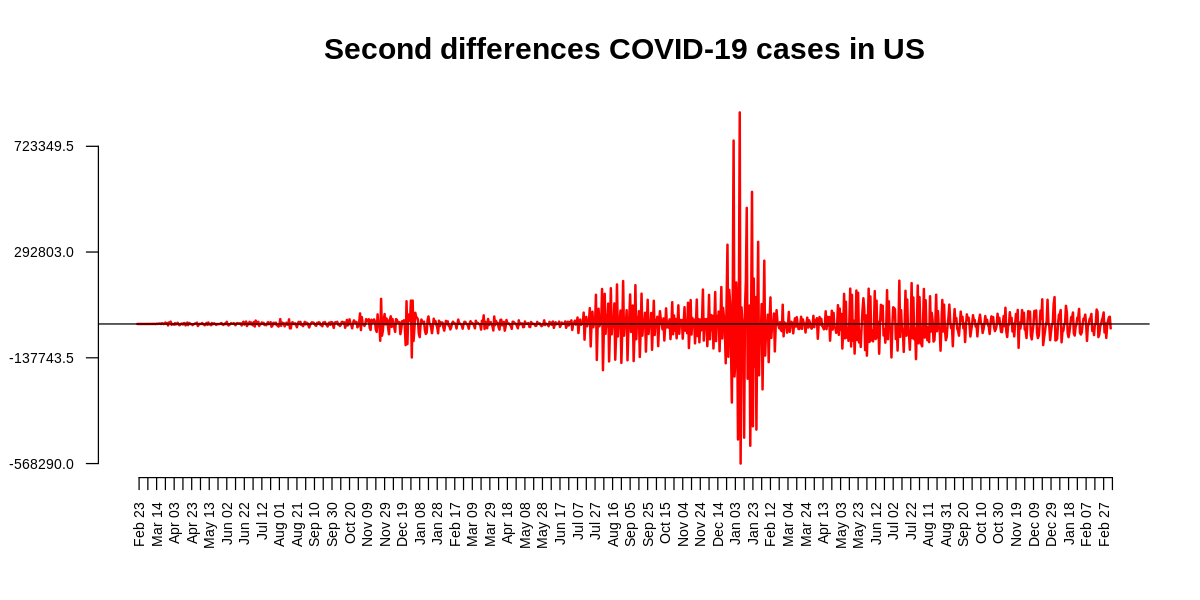

In [23]:
# Analyzing second differences in the number of cases in the US:

options(repr.plot.width=10, repr.plot.height=5)

first.der.US<-diff(ccw$US, lag = 1, differences = 1)
sec.der.US <- diff(ccw$US, lag = 1, differences = 2)

plot(ccw$date[2:length(ccw$date)-2], sec.der.US, 
     type="l", lwd=2, lty=1,
     ylab='', 
     xlab='',
     main ='Second differences COVID-19 cases in US',
     col="red",
     axes=FALSE,
     cex.main=1.5)
abline(h=0)
at1 <- seq(min(ccw$date)+2, max(ccw$date), by=10);
axis.Date(1, at=at1, format="%b %d", las=2, cex.axis=0.7)
axis(side=2, seq(min(sec.der.US),max(sec.der.US),0.5*max(sec.der.US)), 
     las=2, cex.axis=0.7)

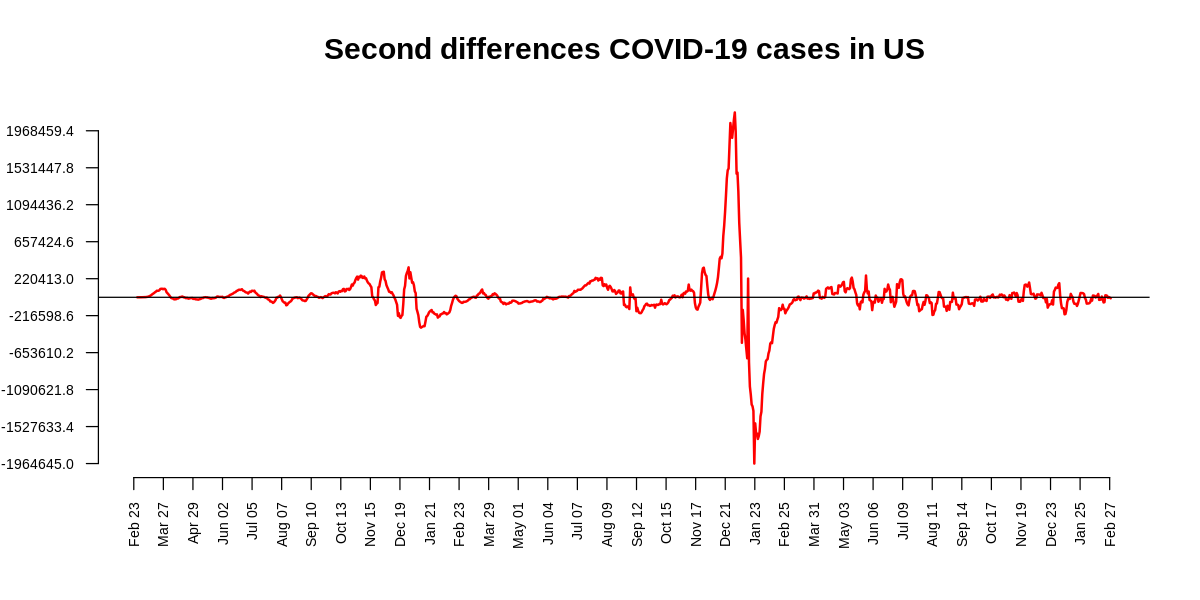

In [24]:
# Trying to get rid of day-to-day noise by sampling every 7 days:
Lag  = 7
Diff = 2
L = length(ccw$US) - Diff * Lag
sec.der.US <- diff(ccw$US, lag = Lag, differences = Diff)

plot(ccw$date[Lag:(Lag + L-1)], sec.der.US, 
     type="l", lwd=2, lty=1,
     ylab='', 
     xlab='',
     main ='Second differences COVID-19 cases in US',
     col="red",
     axes=FALSE,
     cex.main=1.5)
abline(h=0)
at1 <- seq(min(ccw$date)+2, max(ccw$date), by=0.03 * (max(ccw$date) - min(ccw$date)));
axis.Date(1, at=at1, format="%b %d", las=2, cex.axis=0.7)
axis(side=2, seq(min(sec.der.US),max(sec.der.US), 0.2*max(sec.der.US)), 
     las=2, cex.axis=0.7)

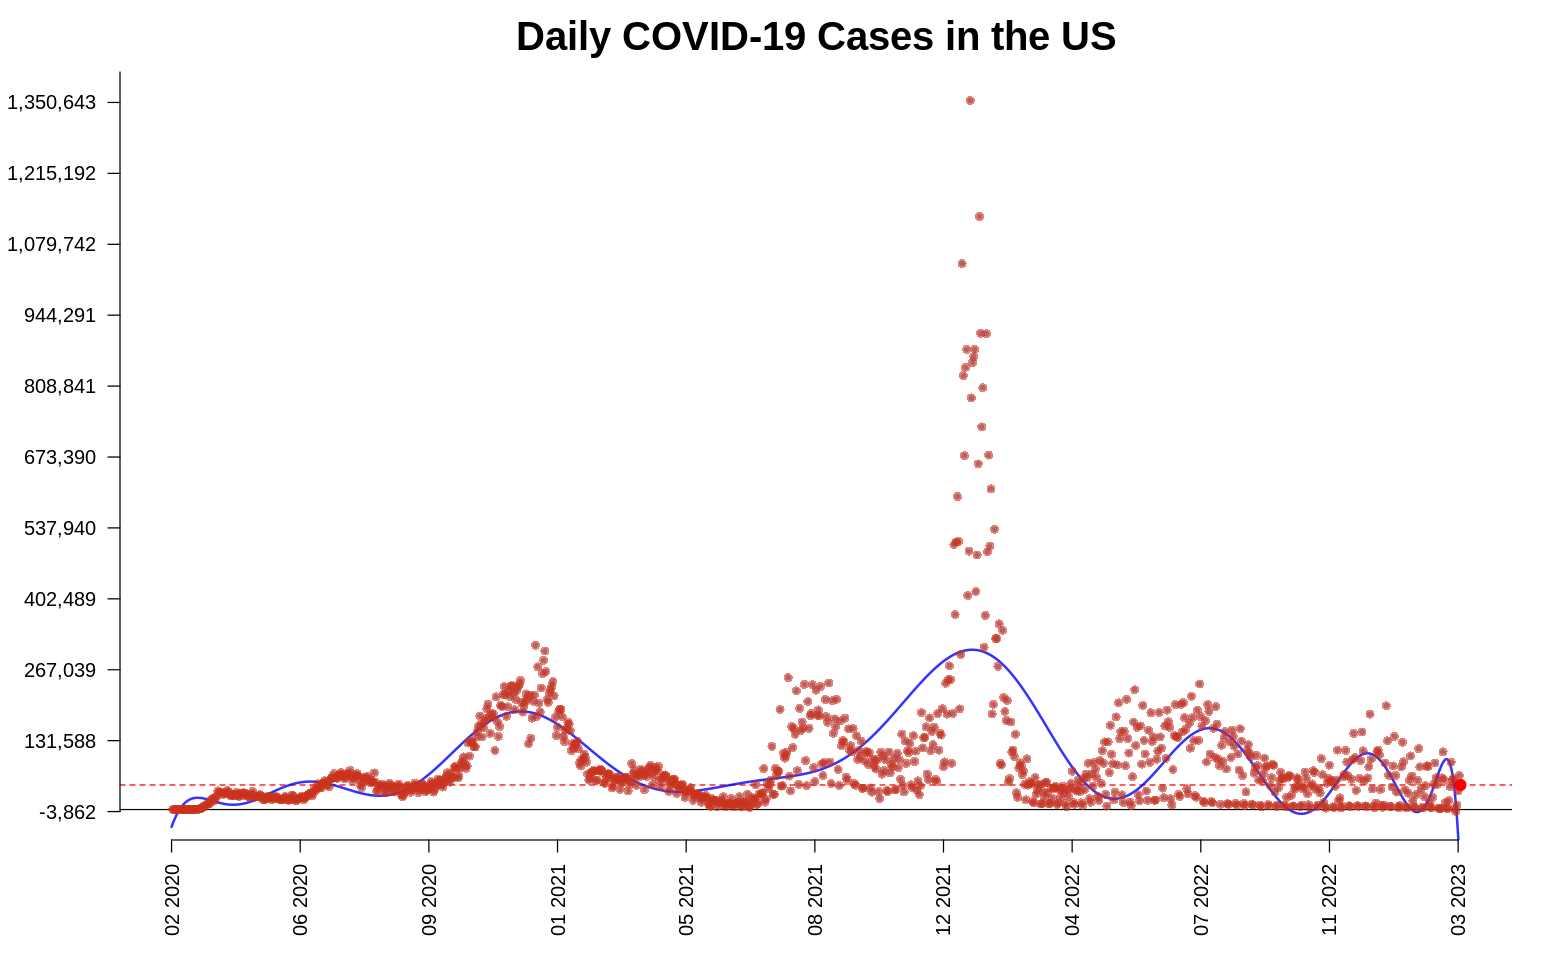

In [25]:
options(scipen = 0)

options(repr.plot.width=13, repr.plot.height=8)

ccw$first.der <- c(NA, diff(ccw$US))  ## better add an NA and integrate in data frame
ccw$day <- seq_along(ccw$date)

n = 25
fitpoly <- lm(first.der ~ poly(day, n, raw=TRUE), ccw[-1, ]) # (polynomial degree n). Hello Weierstrass. 

par(mar=c(5,5,3,2))
with(ccw, plot(day, first.der, 
      main="Daily COVID-19 Cases in the US", cex.main=2,
      axes=FALSE,
      xlab='', 
      ylab='',
      las = 2,
      col=rgb(0.4,0.4,0.8,0.6), pch = 16, cex = .6))

abline(h=0)
abline(h=ccw$first.der[length(ccw$day)], col='red', lty=2)

tck <- seq(min(ccw$day), max(ccw$day), by=round(0.1 * (max(ccw$day) - min(ccw$day))))
axis(1, tck, labels=FALSE)
mtext(strftime(ccw$date[tck], "%m %Y"), 1, 1, at=tck, las=2)

at2 <- seq(min(first.der),max(first.der)+150000, 0.10 * max(first.der))
axis(side=2, at2, las=2, cex.axis=1, labels = formatC(at2, big.mark = ",", format = "d"))

lines(fitpoly$fitted.values, col=alpha('blue',.8), lwd=2)
points(ccw$day, ccw$first.der, main="US covid-19", pch=16, col=rgb(0.8,0.2,0.1,0.6))
points(tail(ccw$day,1), last(ccw$first.der), main="US covid-19", pch=19, cex=1.2, col='red')

$$\text{first deriv} \sim \text{Intercept} + \text{day} + \text{day}^2 +\cdots + \text{day}^n$$


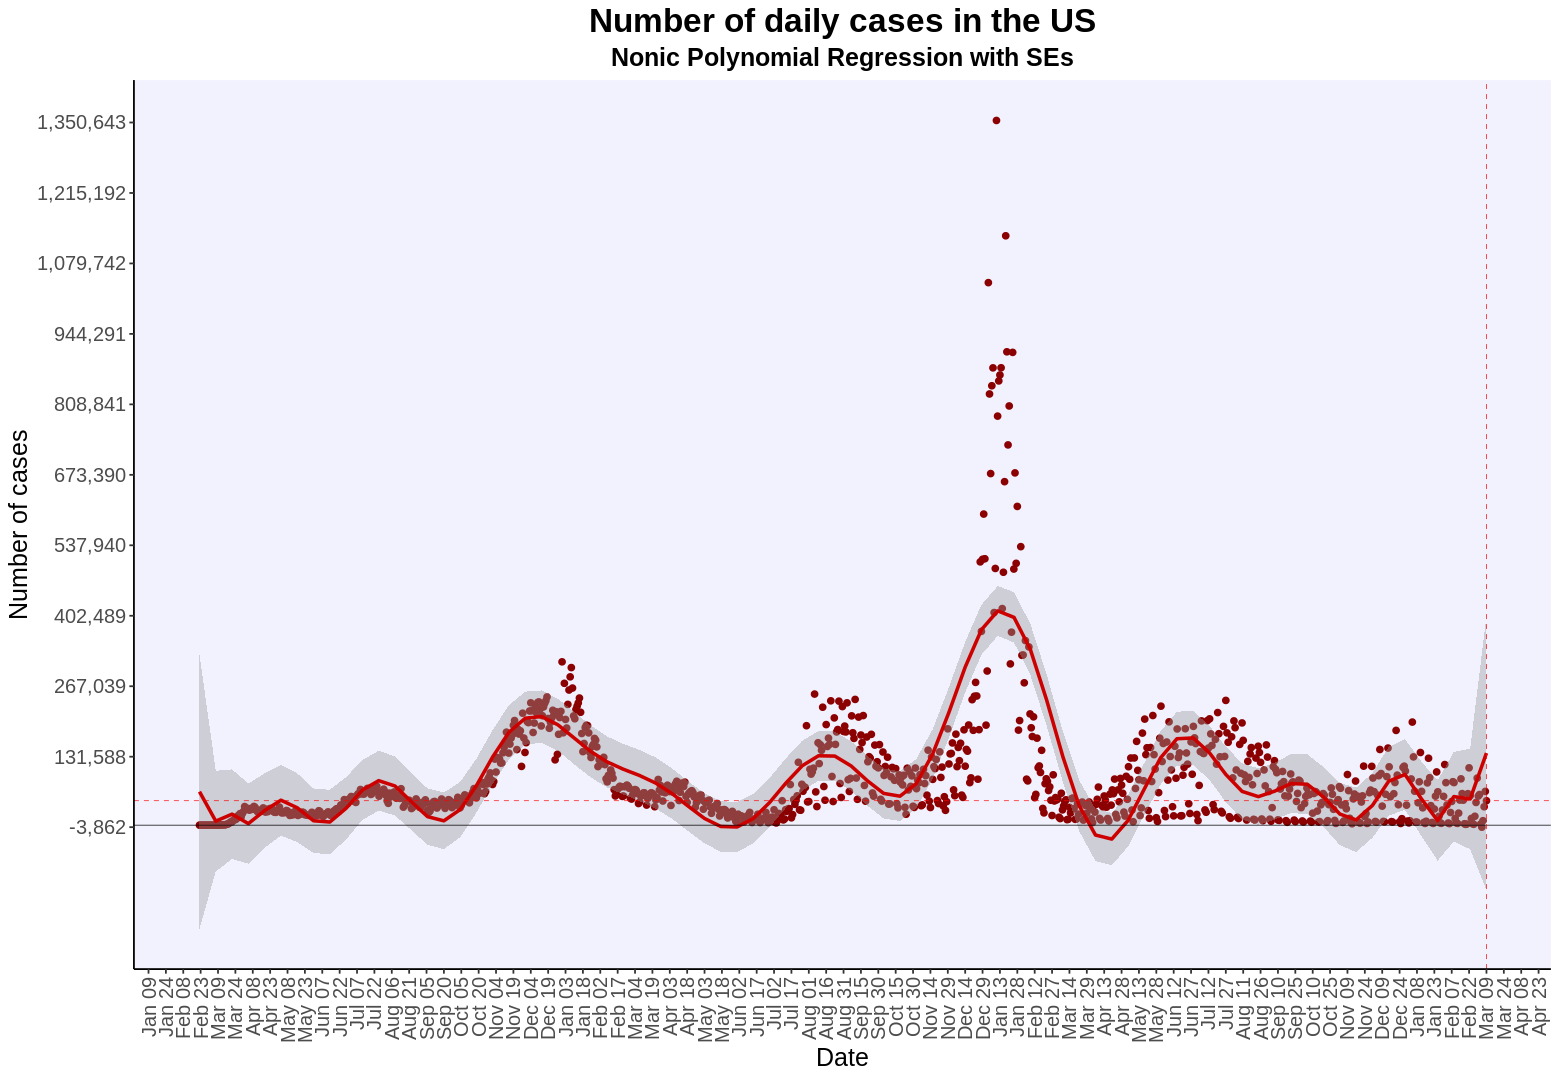

In [26]:
  options(scipen = 999)
  options(repr.plot.width=13, repr.plot.height=9)
  
  ggplot(ccw, aes(x = date, y = first.der)) + 
  theme_classic() +
  labs(y="Number of cases", x = "Date", 
      title="Number of daily cases in the US", subtitle = 'Nonic Polynomial Regression with SEs') +
  theme(plot.title = element_text(hjust = 0.5)) +
  theme(plot.title = element_text(size = 20, face = "bold")) +
  theme(plot.subtitle = element_text(hjust = 0.5)) +
  theme(plot.subtitle = element_text(size = 15, face = "bold")) +
  geom_point(size=1.5, color='red4') +
  scale_y_continuous(breaks = round(seq(min(first.der), max(first.der), by = 0.1 * max(first.der)),1), 
          labels = formatC(round(seq(min(first.der), max(first.der), by = 0.1 * max(first.der)),1), big.mark = ",", format = "d")) +
  geom_smooth(method = "lm", formula = y ~ poly(x, n), level=.99999, 
          color='red3') + 
  theme(text = element_text(size=15)) +
  scale_x_date(date_labels = '%b %d', breaks = '15 days') + 
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  theme(panel.background = element_rect(fill = grDevices::rgb(0, 0, 100, 5, maxColorValue = 100))) +
  geom_hline(yintercept=0, lwd=.2) +
  geom_hline(yintercept=ccw$first.der[length(ccw$day)], col='red', lty=2, lwd=.2) +
  geom_vline(xintercept=tail(ccw$date,1), col='red', lty=2, lwd=.2)

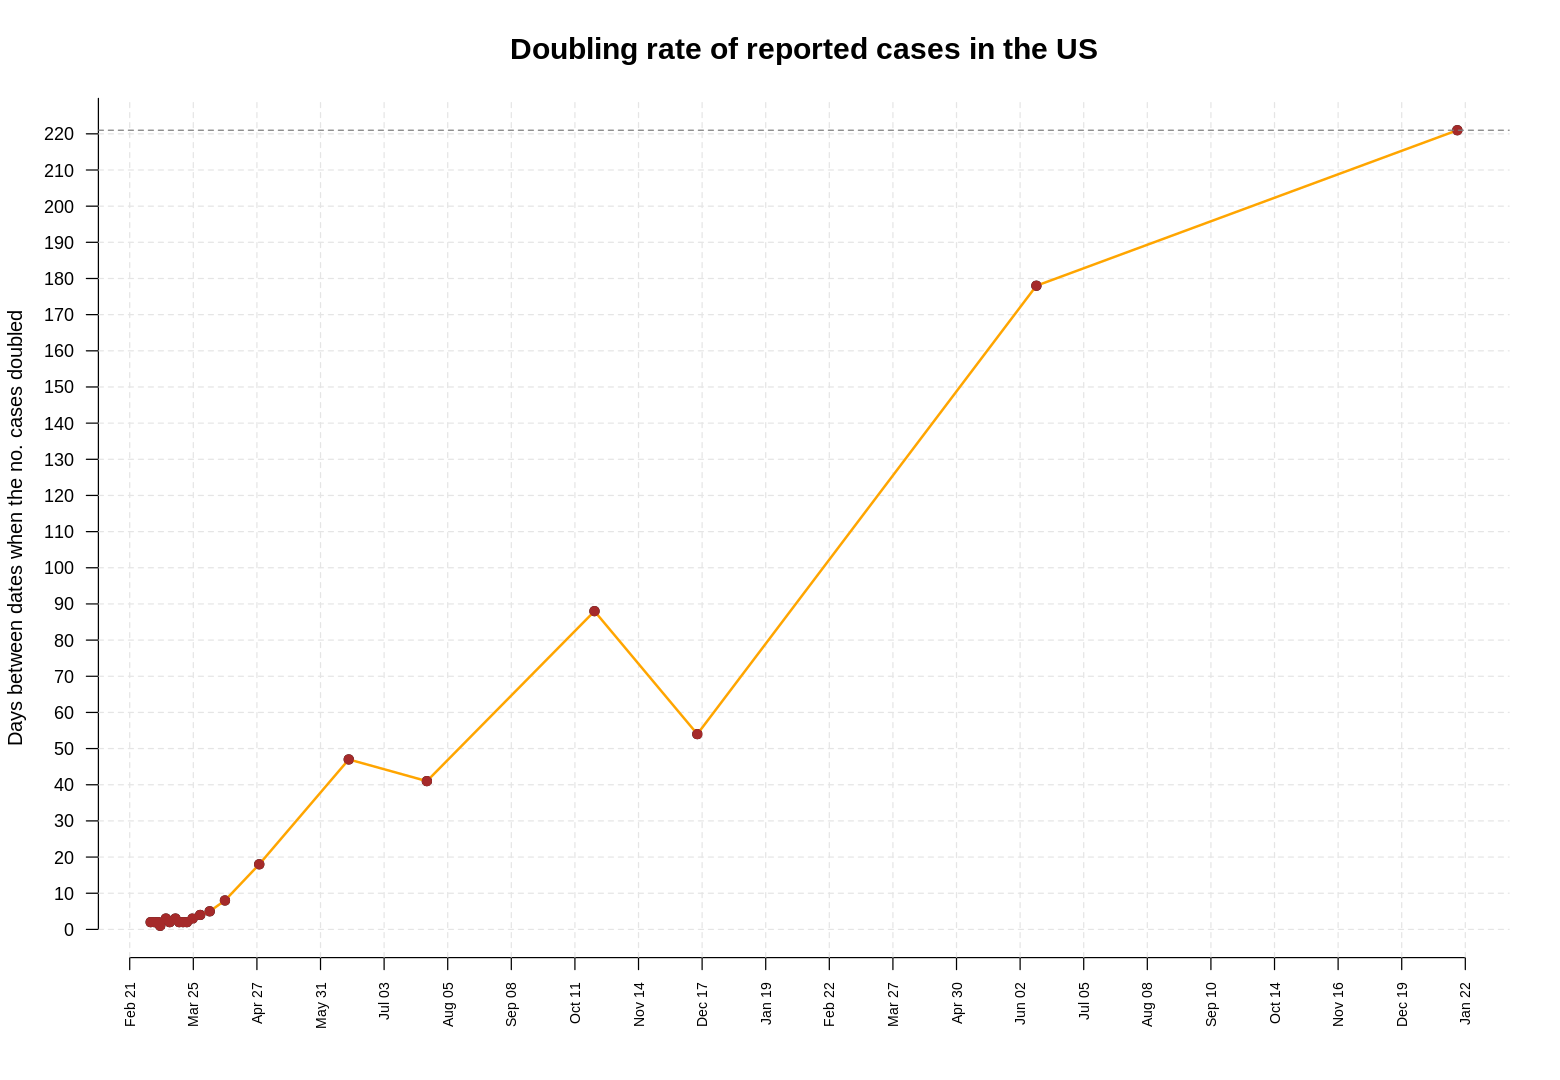

In [27]:
# Doubling time in the number of cases in the US:

v <- numeric(0)
for (i in 1:length(2^seq(3,floor(log2(max(ccw$US)))))){
  v[i] <- min(which(ccw$US >= 2^seq(3,floor(log2(max(ccw$US))))[i]))
}

x2dates <- ccw[unique(v),]


doubling_times <- c(diff.Date(x2dates$date)[1],diff.Date(x2dates$date))
x2dates <- cbind(x2dates,doubling_times)
x2dates <- x2dates[3:nrow(x2dates),]
plot(x2dates$date, x2dates$doubling_times, 
     pch=19,
     xlab='',
     ylab='Days between dates when the no. cases doubled',
     axes=F,
     cex.axis=0.9,
     las=2,
     main = "Doubling rate of reported cases in the US",
     cex.main=1.5,
     bty='l')

at1 <- seq(min(ccw$date), max(ccw$date)+20, by=0.03*length(ccw$date))
axis.Date(1, at=at1, format="%b %d", las=2, cex.axis=0.7)


at2 <- seq(0, 300, by=10);
axis(side=2, at2, cex.axis=0.9, las=2)
abline(v=at1, lty=2, col="grey90")  # Add faint grid lines
abline(h=at2, lty=2, col="grey90")  # Add faint grid lines


lines(x2dates$date, x2dates$doubling_times, lwd=2, col="orange")
points(x2dates$date, x2dates$doubling_times, pch=19, col="brown")
abline(h=tail(x2dates$doubling_times,1), lty=2, col='gray50')

In [28]:
paste("The initial",ccw$US[1] ,"cases have doubled",length(x2dates$doubling_times),"times for a total number of cases of", 
      formatC(tail(ccw$US,1), big.mark = ",", format = "d"),"cases. This is ", round(tail(ccw$US,1)/(popUS*10^6)*100), "percent of the population.")

[1] "The initial 16 cases have doubled 21 times for a total number of cases of 103,802,702 cases. This is  32 percent of the population."

In [29]:
paste("The last time the cases doubled there were",formatC(tail(ccw$US[v],1), big.mark = ",", format = "d"), "cases reported in the US.")
paste("... now there are", formatC(tail(ccw$US,1), big.mark = ",", format = "d"), "cases reported in the US." )

[1] "The last time the cases doubled there were 68,003,787 cases reported in the US."

[1] "... now there are 103,802,702 cases reported in the US."

In [30]:
paste(max(x2dates$doubling_times),"days was the longest doubling period.")

[1] "221 days was the longest doubling period."

In [31]:
United.States.pop <- 328000000
predicted.to.almost.all <- floor(log2(United.States.pop/tail(ccw$US,1)))

paste("The cases can only double",predicted.to.almost.all,
    "times before almost every person is infected. This would possibly take", 
    predicted.to.almost.all*tail(x2dates$doubling_times,1),"days at the latest doubling time.")

[1] "The cases can only double 1 times before almost every person is infected. This would possibly take 221 days at the latest doubling time."

In [32]:
paste("The expected next doubling of cases is no later than", tail(x2dates$date,1)+ as.numeric(max(x2dates$doubling_times)),".")

[1] "The expected next doubling of cases is no later than 2022-08-27 ."

In [33]:
paste("And the next doubling no later than", tail(x2dates$date,1) + 2 * as.numeric(max(x2dates$doubling_times)),".")

[1] "And the next doubling no later than 2023-04-05 ."

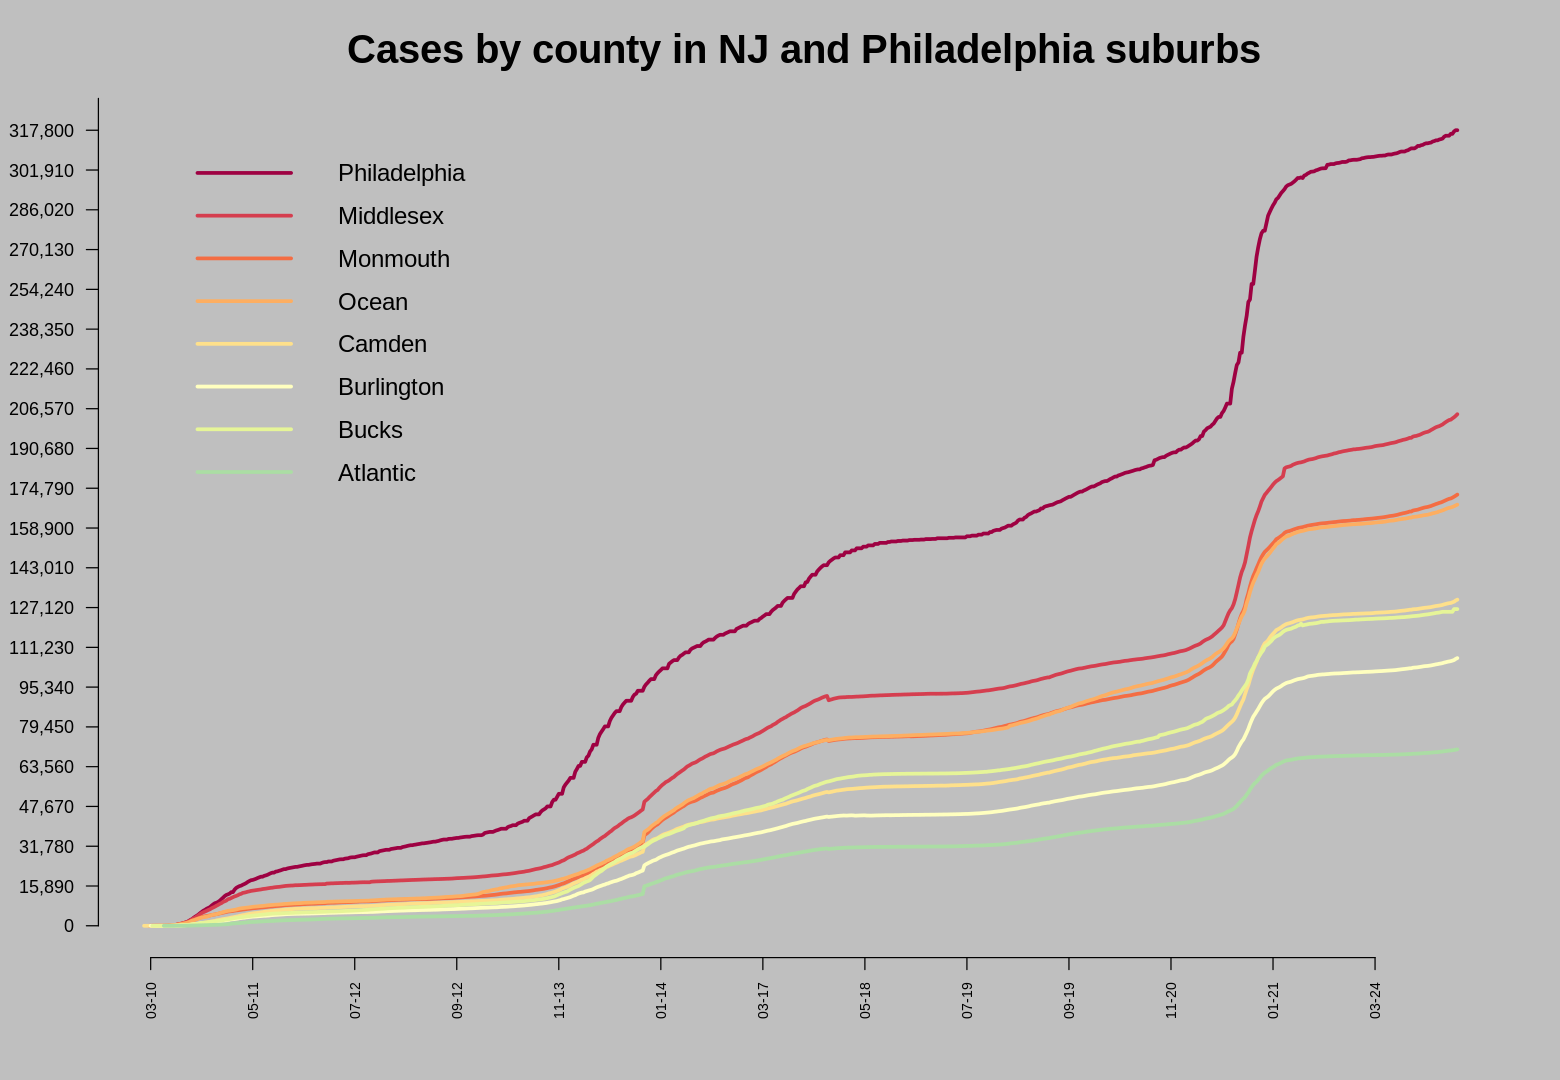

In [34]:
# Cases by county in NJ and Philadelphia suburbs:

states = read.csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv", sep =",",header = T)
states <- states %>%
  mutate(date = as.POSIXct(date, format = '%Y-%m-%d'))

counties = read.csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv", sep =",",header = T)
counties <- counties %>%
  mutate(date = as.POSIXct(date, format = '%Y-%m-%d'))


Burlington <- counties[counties$state=="New Jersey" & counties$county=="Burlington",]
Burlington <- droplevels(Burlington)
rownames(Burlington) <- NULL

Ocean <- counties[counties$state=="New Jersey" & counties$county=="Ocean",]
Ocean <- droplevels(Ocean)
rownames(Ocean) <- NULL

Atlantic <- counties[counties$state=="New Jersey" & counties$county=="Atlantic",]
Atlantic <- droplevels(Atlantic)
rownames(Atlantic) <- NULL

Camden <- counties[counties$state=="New Jersey" & counties$county=="Camden",]
Camden <- droplevels(Camden)
rownames(Camden) <- NULL

Monmouth <- counties[counties$state=="New Jersey" & counties$county=="Monmouth",]
Monmouth <- droplevels(Monmouth)
rownames(Monmouth) <- NULL

Middlesex <- counties[counties$state=="New Jersey" & counties$county=="Middlesex",]
Middlesex <- droplevels(Middlesex)
rownames(Middlesex) <- NULL

Philadelphia <- counties[counties$state=="Pennsylvania" & counties$county=="Philadelphia",]
Philadelphia <- droplevels(Philadelphia)
rownames(Philadelphia) <- NULL

Bucks <- counties[counties$state=="Pennsylvania" & counties$county=="Bucks",]
Bucks <- droplevels(Bucks)
rownames(Bucks) <- NULL

par(bg = 'gray75')
with(as.data.frame(Philadelphia), 
     plot(date, cases,axes=FALSE, xlab="", ylab="", cex.axis=0.8, type="l", lwd=3,
          cex.main=2, las=2, bty='l', col=co[1],
          main="Cases by county in NJ and Philadelphia suburbs"))

ats <- seq(trunc(min(Philadelphia$date), "days"), trunc(max(Philadelphia$date), "days"), by=paste(round(0.001 * nrow(states)),'days'))
axis.POSIXct(1, ats, at=ats, 
             labels=format(ats,"%m-%d"),
             las=2, cex.axis=0.7)

at2 <- seq(0, 500000, by=round(.05 * max(Philadelphia$cases)))
axis(side=2, at2, 
     las=2, cex.axis=.9, labels = formatC(at2, big.mark = ",", format = "d"))

lines(Middlesex$date, Middlesex$cases, lwd=3, col=co[2])
lines(Monmouth$date, Monmouth$cases, lwd=3, col=co[3])
lines(Ocean$date, Ocean$cases, lwd=3, col=co[4])
lines(Camden$date, Camden$cases, lwd=3, col=co[5])
lines(Burlington$date, Burlington$cases, lwd=3, col=co[6])
lines(Bucks$date, Bucks$cases, lwd=3, col=co[7])
lines(Atlantic$date, Atlantic$cases, lwd=3, col=co[8])


legend(Philadelphia$date[1], max(Philadelphia$cases), bg="transparent",
       legend=c("Philadelphia", "Middlesex", "Monmouth", "Ocean", 
                "Camden", "Burlington", "Bucks", "Atlantic"),
       col=co[1:8], 
       lwd=3, cex=1.2, box.lty=0)     

In [35]:
paste("Total cases in Philadelphia: ", formatC(tail(Philadelphia$cases,1),format="d",big.mark=","))
paste("Total cases in Middlesex: ", formatC(tail(Middlesex$cases,1),format="d",big.mark=","))
paste("Total cases in Monmouth: ", formatC(tail(Monmouth$cases,1),format="d",big.mark=","))
paste("Total cases in Ocean: ", formatC(tail(Ocean$cases,1),format="d",big.mark=","))
paste("Total cases in Camden: ", format(tail(Camden$cases,1),format="d",big.mark=","))
paste("Total cases in Burlington: ", format(tail(Burlington$cases,1),format="d",big.mark=","), "out of 445,349 or ", 
        round(tail(Burlington$cases,1)*100/445349,2), " percent.")
paste("Total cases in Bucks: ", formatC(tail(Bucks$cases,1),format="d",big.mark=","))
paste("Total cases in Atlantic: ", format(tail(Atlantic$cases,1),format="d",big.mark=","))

[1] "Total cases in Philadelphia:  317,808"

[1] "Total cases in Middlesex:  204,363"

[1] "Total cases in Monmouth:  172,251"

[1] "Total cases in Ocean:  168,238"

[1] "Total cases in Camden:  130,289"

[1] "Total cases in Burlington:  106,935 out of 445,349 or  24.01  percent."

[1] "Total cases in Bucks:  126,504"

[1] "Total cases in Atlantic:  70,482"

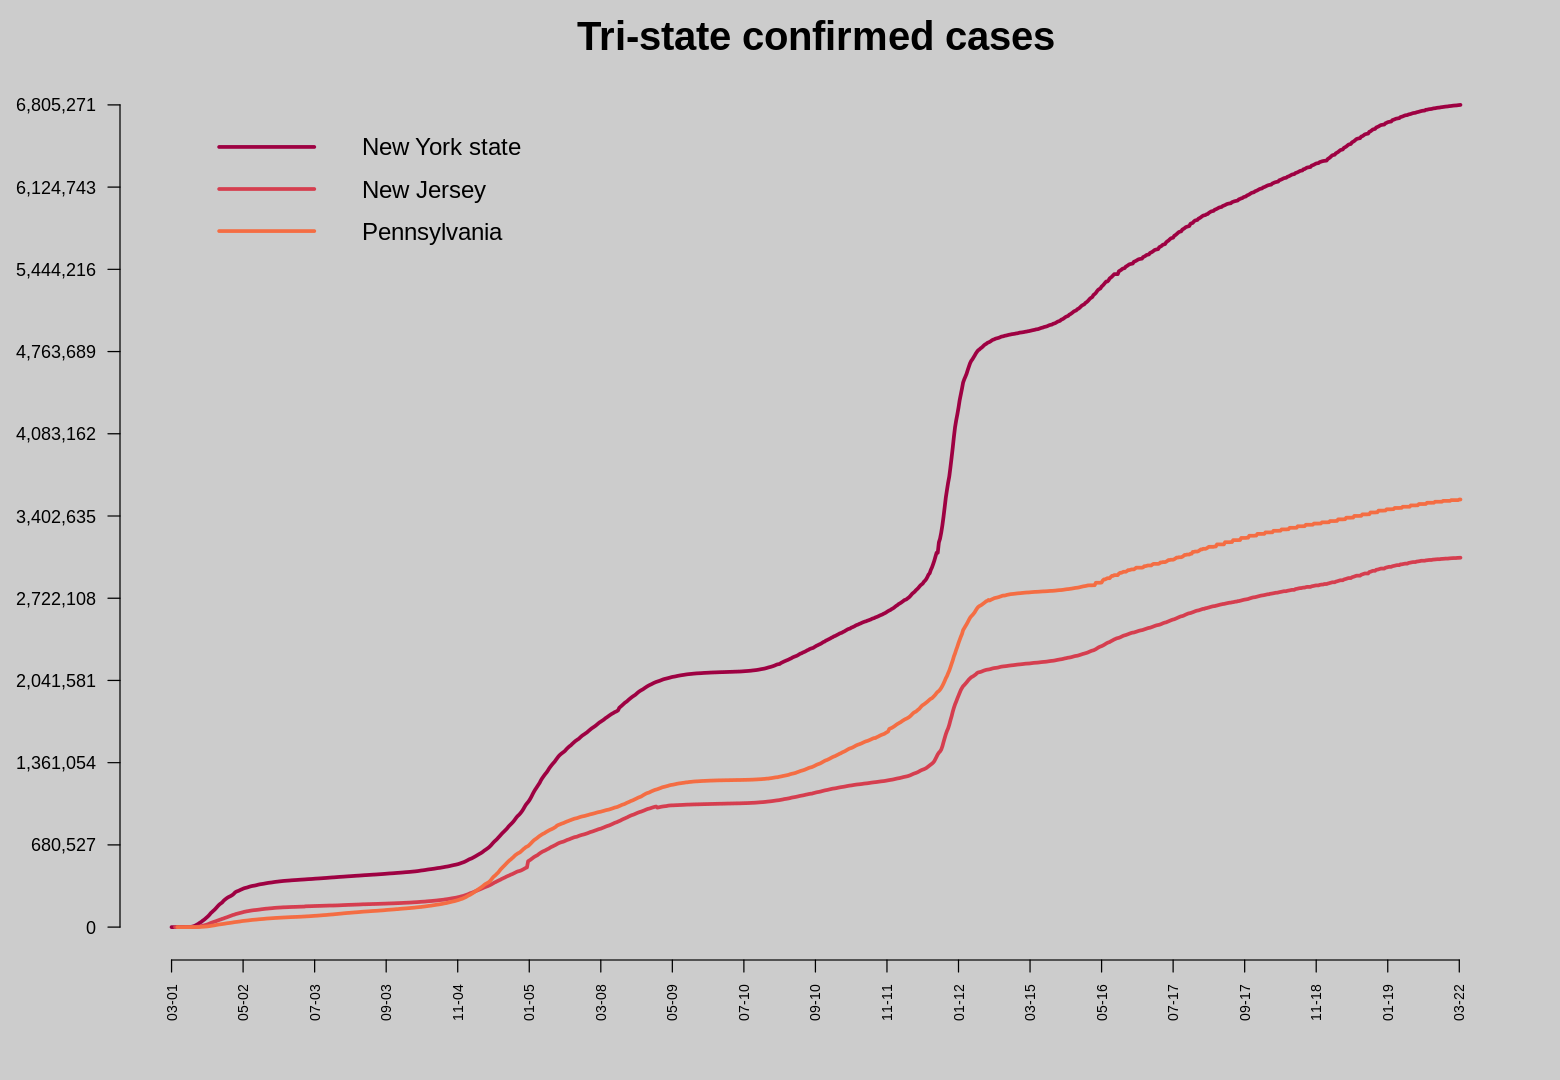

In [36]:
# Tri-state cases (NY, NJ, PA):

NJ <- states[states$state=="New Jersey",]
NJ <- droplevels(NJ)
rownames(NJ) <- NULL

NY <- states[states$state=="New York",]
NY <- droplevels(NY)
rownames(NY) <- NULL

PA <- states[states$state=="Pennsylvania",]
PA <- droplevels(PA)
rownames(PA) <- NULL

par(mar=c(5,5,3,2))
par(bg = 'gray80')
with(as.data.frame(NY),
     plot(date,cases,axes=FALSE, xlab="", ylab="", type='l', lwd=3,
          cex.axis=0.6, col=co[1],
          cex.main=2, las=2, bty='l',
          main="Tri-state confirmed cases"))

ats <- seq(trunc(min(NY$date), "days"), trunc(max(NY$date), "days"), by=paste(round(0.001 * nrow(states)),'days'))

axis.POSIXct(1,ats, ats,
             labels=format(ats,"%m-%d"),
             las=2, cex.axis=0.7)

at2 <- seq(0, max(NY$cases), by=.1 * max(NY$cases));
axis(side=2, at2, 
     las=2, cex.axis=.9, labels = formatC(at2, big.mark = ",", format = "d"))

lines(NJ$date, NJ$cases, lwd=3, col=co[2])
lines(PA$date, PA$cases, lwd=3, col=co[3])

legend(NY$date[1], max(NY$cases), bg="transparent",
       legend=c("New York state", "New Jersey", "Pennsylvania"),
       col=co[1:3], lwd=3, cex=1.2, box.lty=0)

In [37]:
paste("Total cases in NJ: ", formatC(tail(NJ$cases,1),format="d",big.mark=","))
paste("Total cases in NY: ", formatC(tail(NY$cases,1),format="d",big.mark=","))
paste("Total cases in PA: ", formatC(tail(PA$cases,1),format="d",big.mark=","))

[1] "Total cases in NJ:  3,057,442"

[1] "Total cases in NY:  6,805,271"

[1] "Total cases in PA:  3,539,135"

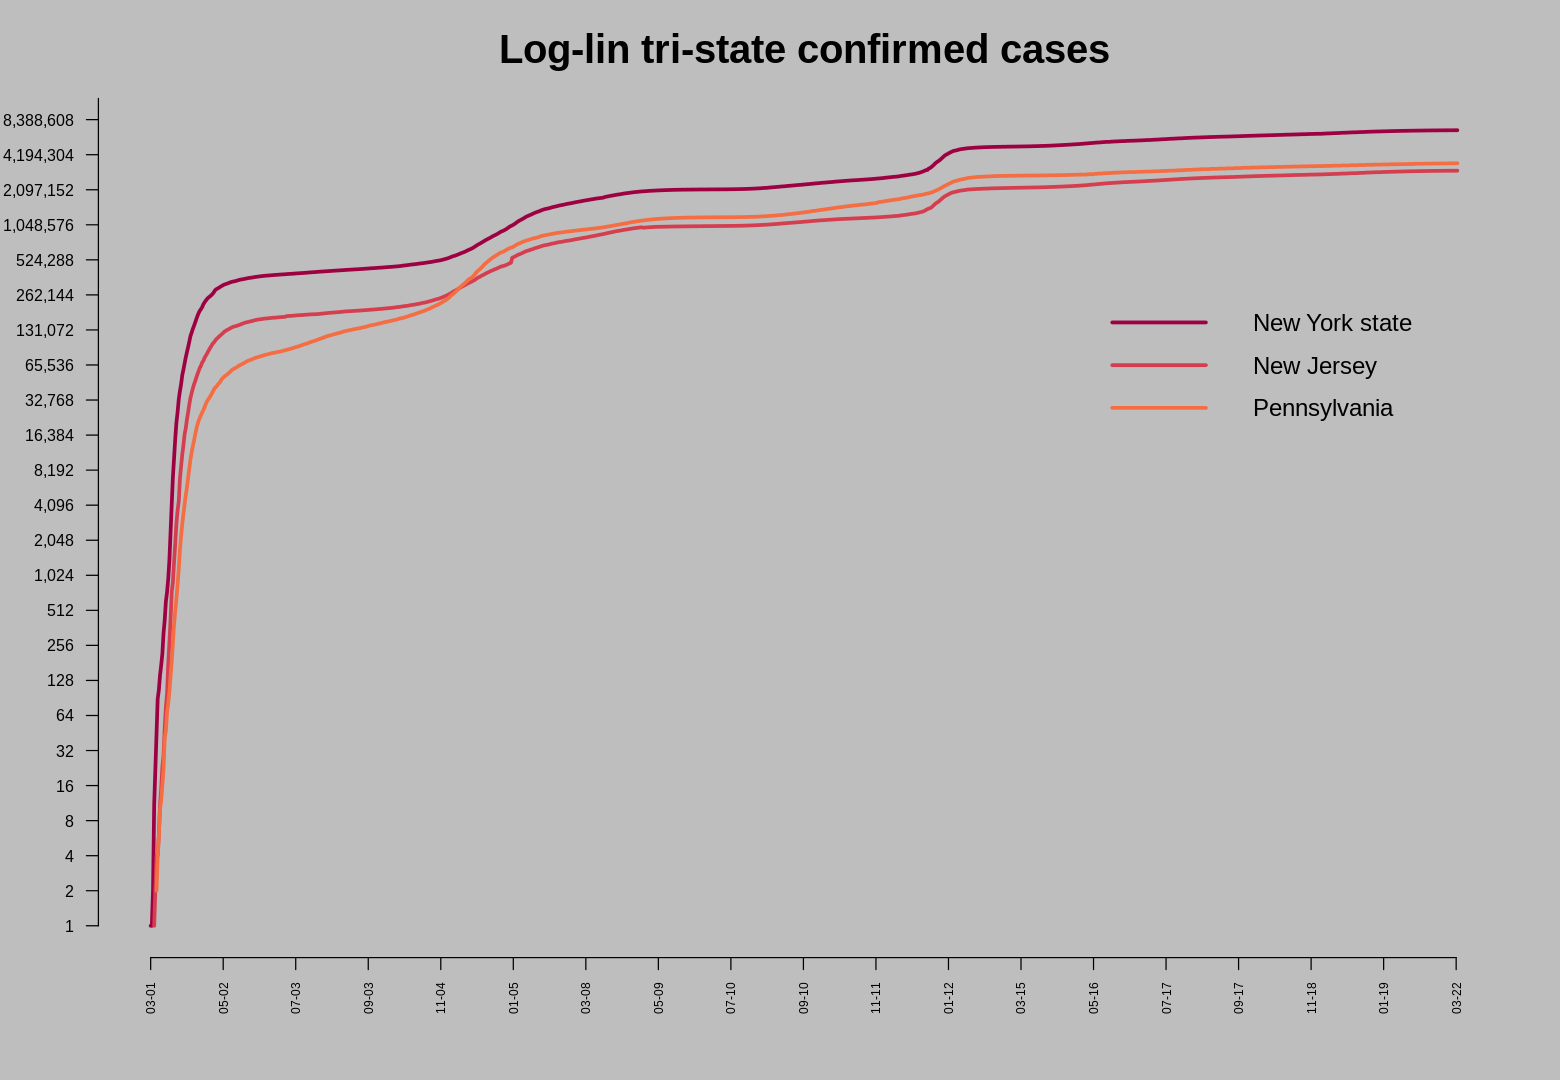

In [38]:
# Log-linear plot of cases in NY, NJ, PA:
par(bg = 'gray')
with(as.data.frame(NY),
     plot(date,cases,axes=FALSE, xlab="", ylab="", type='l', lwd=3, cex.axis=0.8, 
          cex.main=2, las=2, bty='l', log='y', col=co[1],
          main="Log-lin tri-state confirmed cases"))

ats <- seq(trunc(min(NY$date), "days"), trunc(max(NY$date), "days"), by=paste(round(0.001 * nrow(states)),'days'))
axis.POSIXct(1,ats, ats,
             labels=format(ats,"%m-%d"),
             las=2, cex.axis=0.6)

at2 <- 2^seq(0,30,by=1)
axis(side=2, at2, cex.axis=0.8, las=2, labels = formatC(at2, big.mark = ",", format = "d"))

lines(NJ$date, NJ$cases, lwd=3, col=co[2])
lines(PA$date, PA$cases, lwd=3, col=co[3])


legend(NY$date[length(NY$date)-round(0.3*length(NY$date))], 0.1*max(PA$cases),
       legend=c("New York state", "New Jersey", "Pennsylvania"),
       col=co[1:3], lwd=3, cex=1.2, box.lty=0)

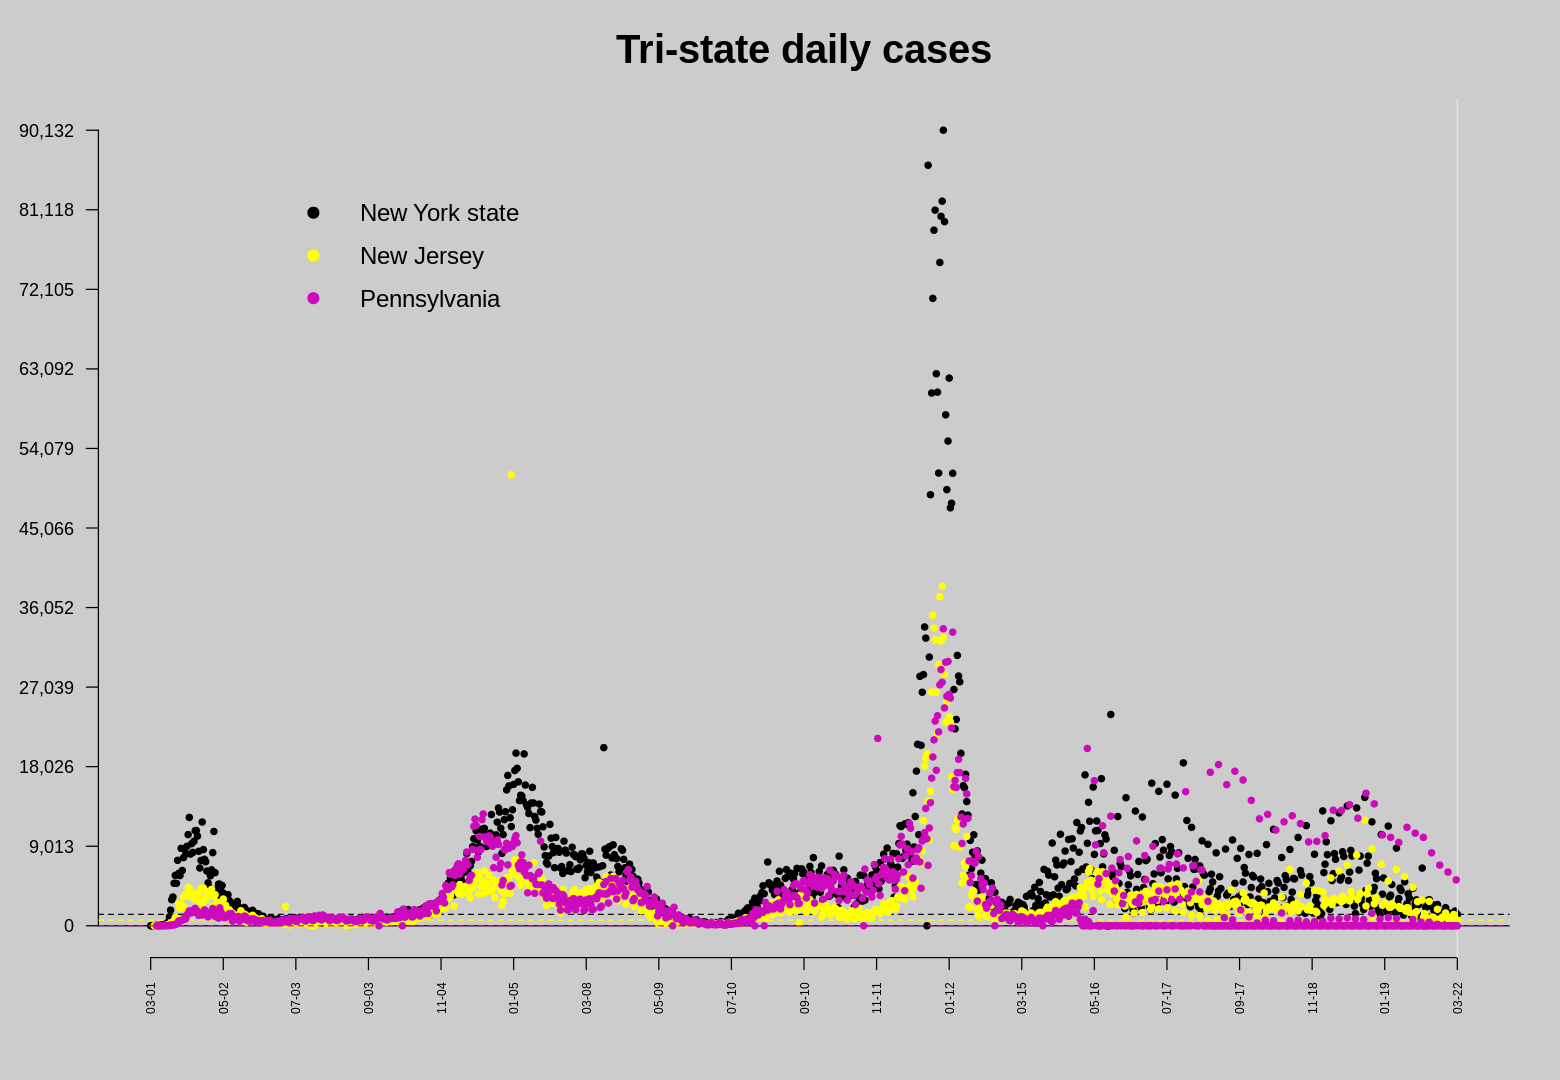

In [39]:
first.diff.NY <- diff(NY$cases, lag = 1, differences = 1)
par(bg = 'gray80')
with(as.data.frame(NY),
     plot(NY$date[2:length(NY$date)-1], first.diff.NY, 
          axes=F, 
          xlab="", ylab="", pch=19, 
          cex.axis=1.2, cex=0.7,
          cex.main=2, las=2, bty='l',
          main="Tri-state daily cases"))

ats <- seq(trunc(min(NY$date), "days"), trunc(max(NY$date), "days"), by=paste(round(0.001 * nrow(states)),'days'))
axis.POSIXct(1,ats, ats,
             labels=format(ats,"%m-%d"),
             las=2, cex.axis=0.6)

at2 <- seq(0, max(first.diff.NY), by=.1 * max(first.diff.NY));
axis(side=2, at2, 
     las=2, cex.axis=.9, labels = formatC(at2, big.mark = ",", format = "d"))

abline(h=0)
abline(v=NY$date[length(NY$date)-1], col='gray90')
abline(h=first.diff.NY[length(NY$date)-1], lty= 2, col=1)

first.diff.NJ <- diff(NJ$cases, lag = 1, differences = 1)
first.diff.PA <- diff(PA$cases, lag = 1, differences = 1)

points(NJ$date[2:length(NJ$date)-1], first.diff.NJ, pch=19, col='yellow', cex=0.7)
abline(h=first.diff.NJ[length(NJ$date)-1], lty=2, col='yellow')
points(PA$date[2:length(PA$date)-1], first.diff.PA, pch=19, col=6, cex=0.7)
abline(h=first.diff.PA[length(PA$date)-1], lty=2, col=6)



legend(NY$date[100], max(first.diff.NY)-0.05*max(first.diff.NY), bg="transparent",
       legend=c("New York state", "New Jersey", "Pennsylvania"),
       col=c(1, 'yellow', 6), pch=19, cex=1.2, box.lty=0)

In [40]:
paste("New cases in NJ: ", tail(first.diff.NJ,1))
paste("New cases in PA: ", tail(first.diff.PA,1))
paste("New cases in NY: ", tail(first.diff.NY,1))

[1] "New cases in NJ:  644"

[1] "New cases in PA:  0"

[1] "New cases in NY:  1297"

In [41]:
dens <- read.csv("https://raw.githubusercontent.com/RInterested/COVID19/master/population%20density.csv", sep=",", header=T)
# Density per square mile of land area

In [42]:
state_pop = read.csv("https://raw.githubusercontent.com/RInterested/DATASETS/905bfd4cdb09f0131be368e4e9d63eef7f44abf2/state_population.csv", sep =",",header = T)
colnames(state_pop)[which(colnames(state_pop)=="NAME")] <- "state"

last_day <- states[states$date==states$date[nrow(states)],]
last_day <- last_day[last_day$state %in% intersect(last_day$state, state_pop$state),]
last_day <- last_day[last_day$state %in% intersect(last_day$state, dens$state),]

last_day <- merge(last_day, state_pop[, c("state", "POPESTIMATE2019")], by="state")
colnames(last_day)[which(colnames(last_day)=="POPESTIMATE2019")] <- "pop"

last_day$perhead <- round(last_day$cases / last_day$pop * 10^5)

last_day <- merge(last_day, dens[,c("state","density")], by="state")

last_day$perheadsqmile <- round(last_day$cases / last_day$density)

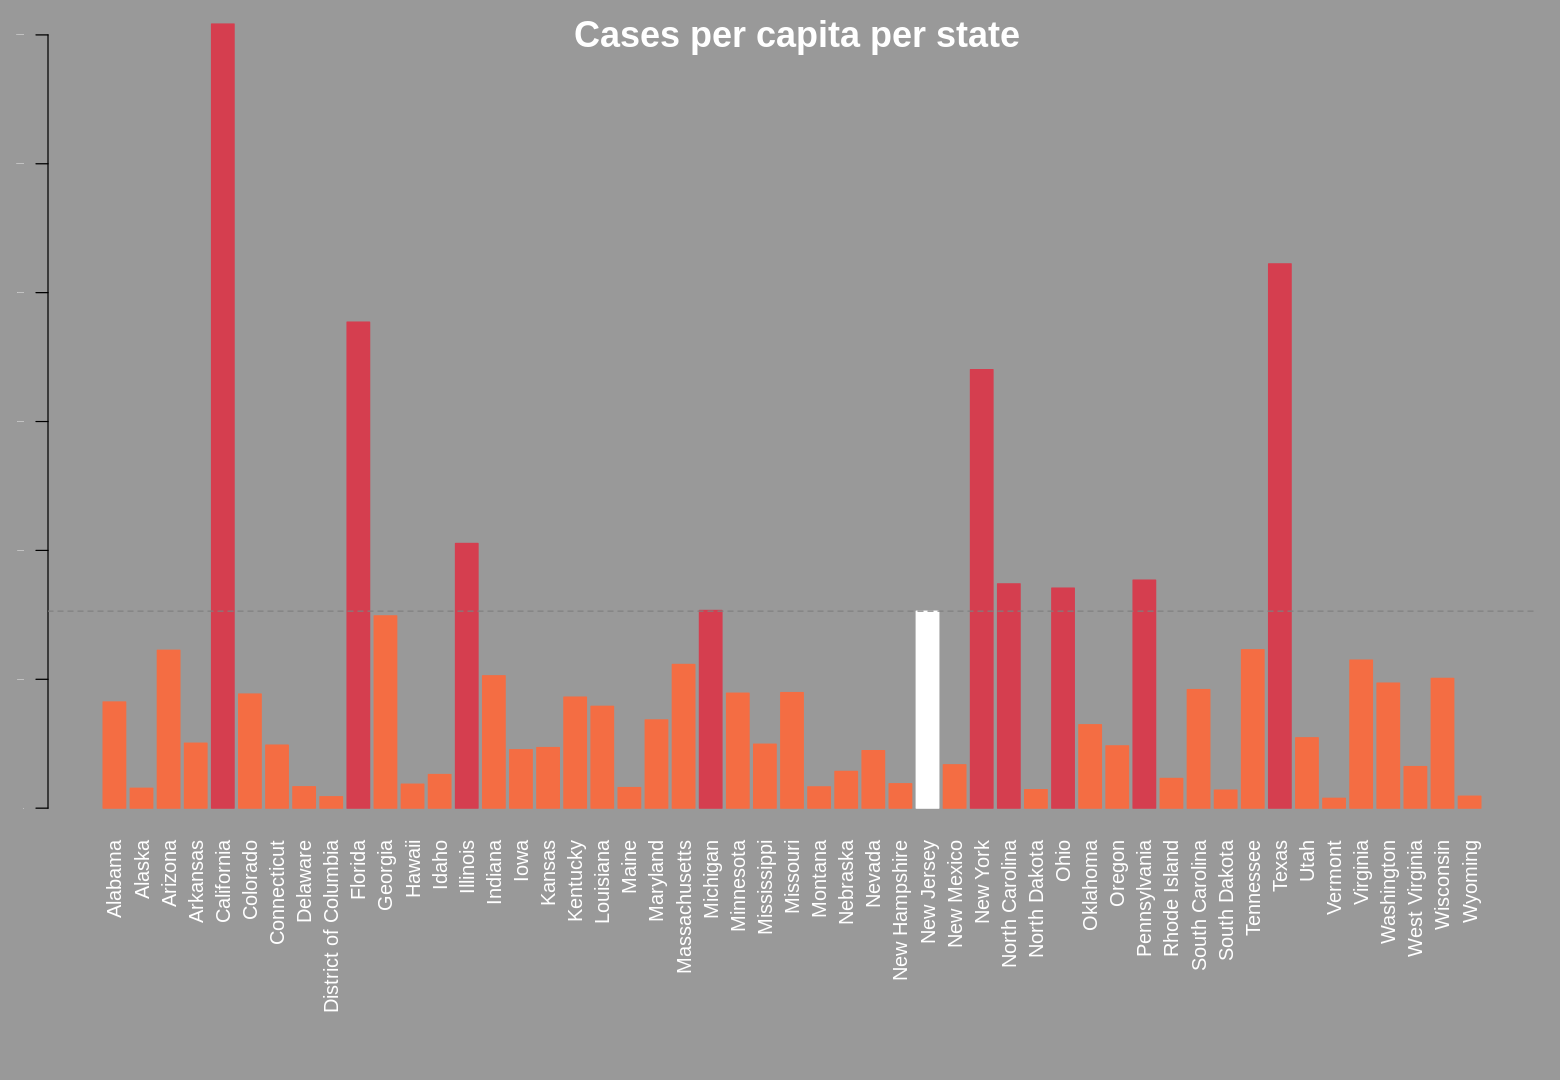

In [43]:
bad <-last_day$state[last_day$cases > last_day$cases[which(last_day$state=='New Jersey')]]

par(bg = 'gray60')
par(mar=c(11,2,1,1))
barplot(with(last_day, 
              tapply(cases, state, FUN = sum)),las=2, cex.axis=.1, 
              col=ifelse(last_day$state=='New Jersey', 'white',
                  ifelse(last_day$state %in% bad, co[2], co[3])), 
              border=ifelse(last_day$state=='New Jersey', 'white',
                  ifelse(last_day$state %in% bad, co[2], co[3])),
                main="\n Cases per capita per state", cex.main=1.8, col.main='white', col.axis='white')
abline(h = last_day$cases[which(last_day$state=='New Jersey')], lty=2, col='grey50')

In [44]:
paste("NJ is the", length(bad) + 1, " state with most COVID cases.")

[1] "NJ is the 10  state with most COVID cases."

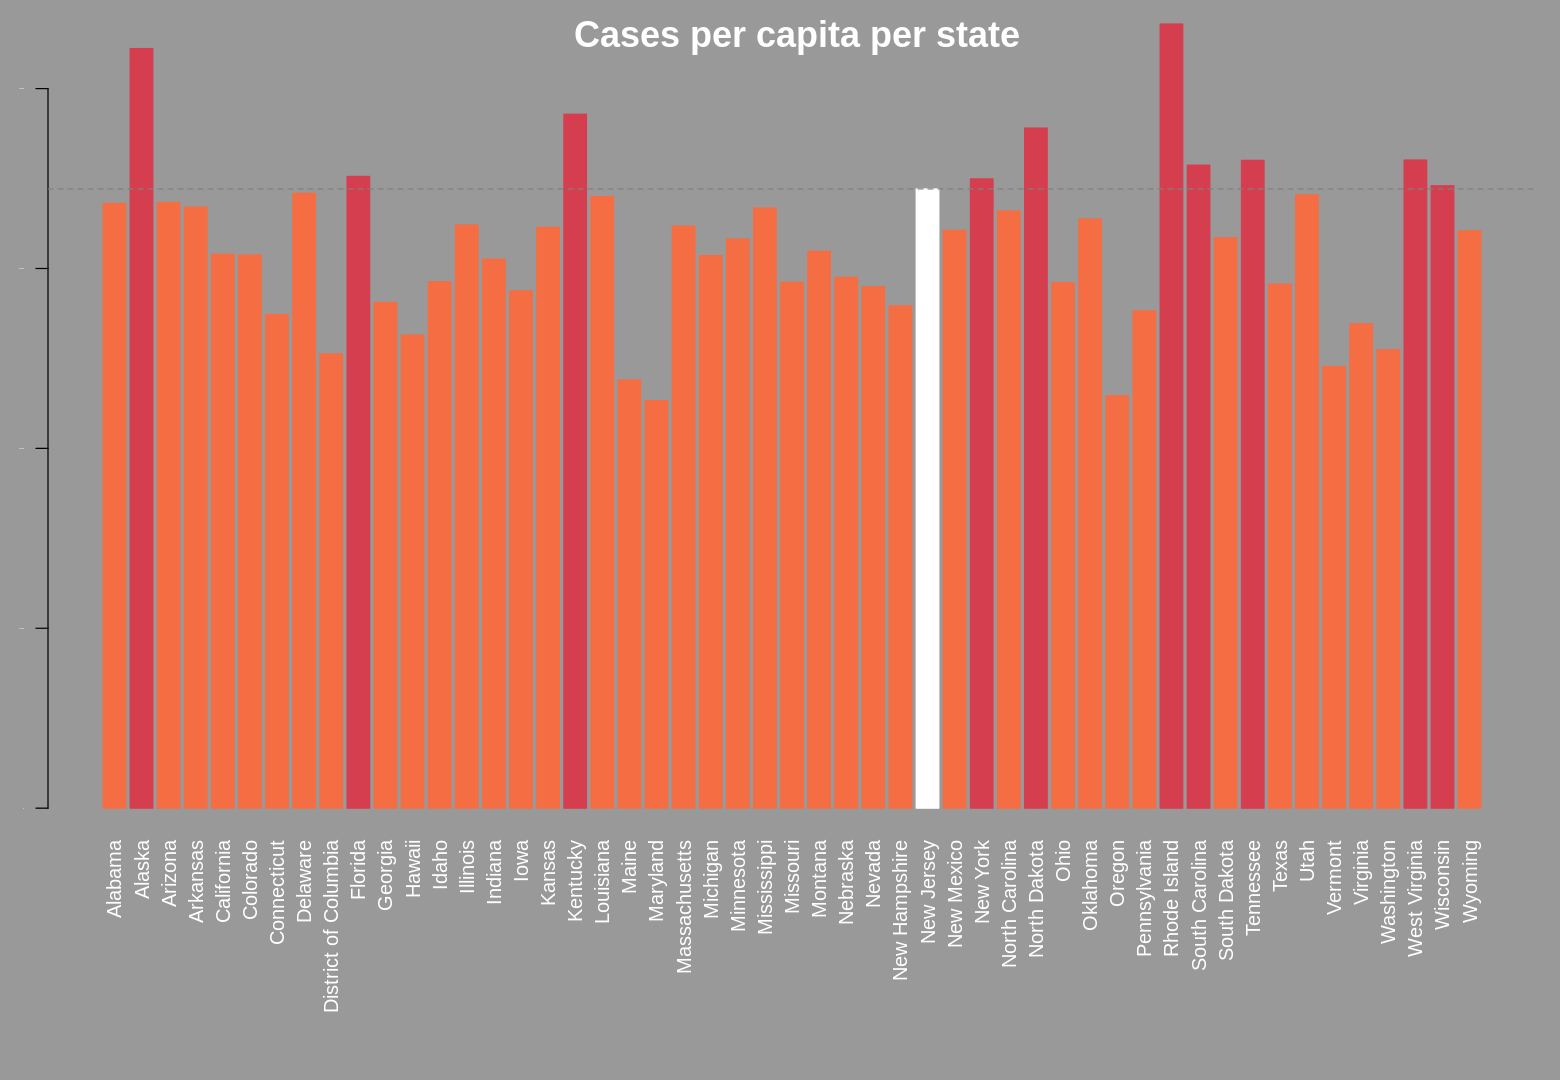

In [45]:
badpercapita <-last_day$state[last_day$perhead > last_day$perhead[which(last_day$state=='New Jersey')]]
par(bg = 'gray60')
par(mar=c(11,2,1,1))
barplot(with(last_day, 
              tapply(perhead, state, FUN = sum)), las=2, cex.axis=.1, 
              col=ifelse(last_day$state=='New Jersey','white',
                  ifelse(last_day$state %in% badpercapita, co[2], co[3])), 
              border=ifelse(last_day$state=='New Jersey','white', 
              ifelse(last_day$state %in% badpercapita, co[2], co[3])), col.axis='white',
              main="\n Cases per capita per state", cex.main=1.8, col.main='white')
abline(h = last_day$perhead[which(last_day$state=='New Jersey')], lty=2, col='grey50')

In [46]:
paste("NJ is the", length(badpercapita) + 1, "state with most COVID cases per capita.")

[1] "NJ is the 11 state with most COVID cases per capita."

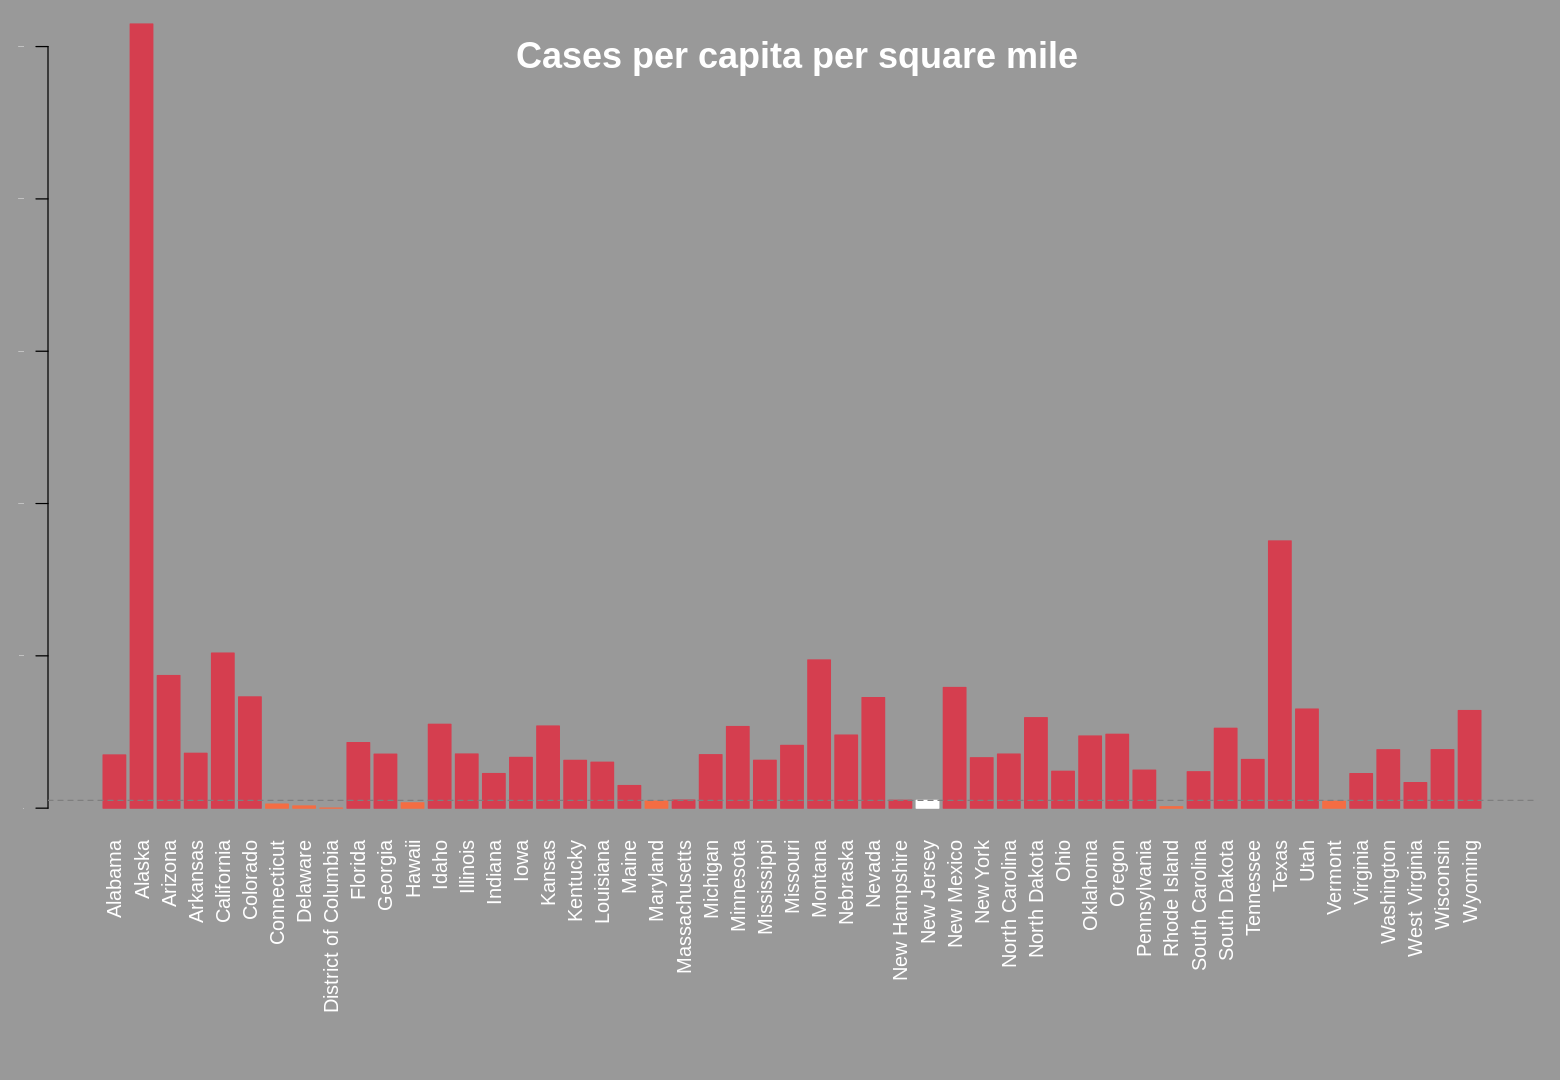

In [47]:
badperdensity <-last_day$state[last_day$perheadsqmile > last_day$perheadsqmile[which(last_day$state=='New Jersey')]]
par(bg = 'gray60')
par(mar=c(11,2,1,1))
barplot(with(last_day, 
              tapply(perheadsqmile, state, FUN = sum)),las=2, cex.axis=.1, 
              col=ifelse(last_day$state=='New Jersey', 'white',
                  ifelse(last_day$state %in% badperdensity, co[2], co[3])), 
              border=ifelse(last_day$state=='New Jersey', 'white', ifelse(last_day$state %in% badperdensity, co[2], co[3])),
              main="\n \n Cases per capita per square mile", cex.main=1.8, col.main='white', col.axis='white')
abline(h = last_day$perheadsqmile[which(last_day$state=='New Jersey')], lty=2, col='grey50')

In [48]:
paste("NJ is the", length(badperdensity) + 1, "state with least COVID cases capita in a square mile.")

[1] "NJ is the 44 state with least COVID cases capita in a square mile."

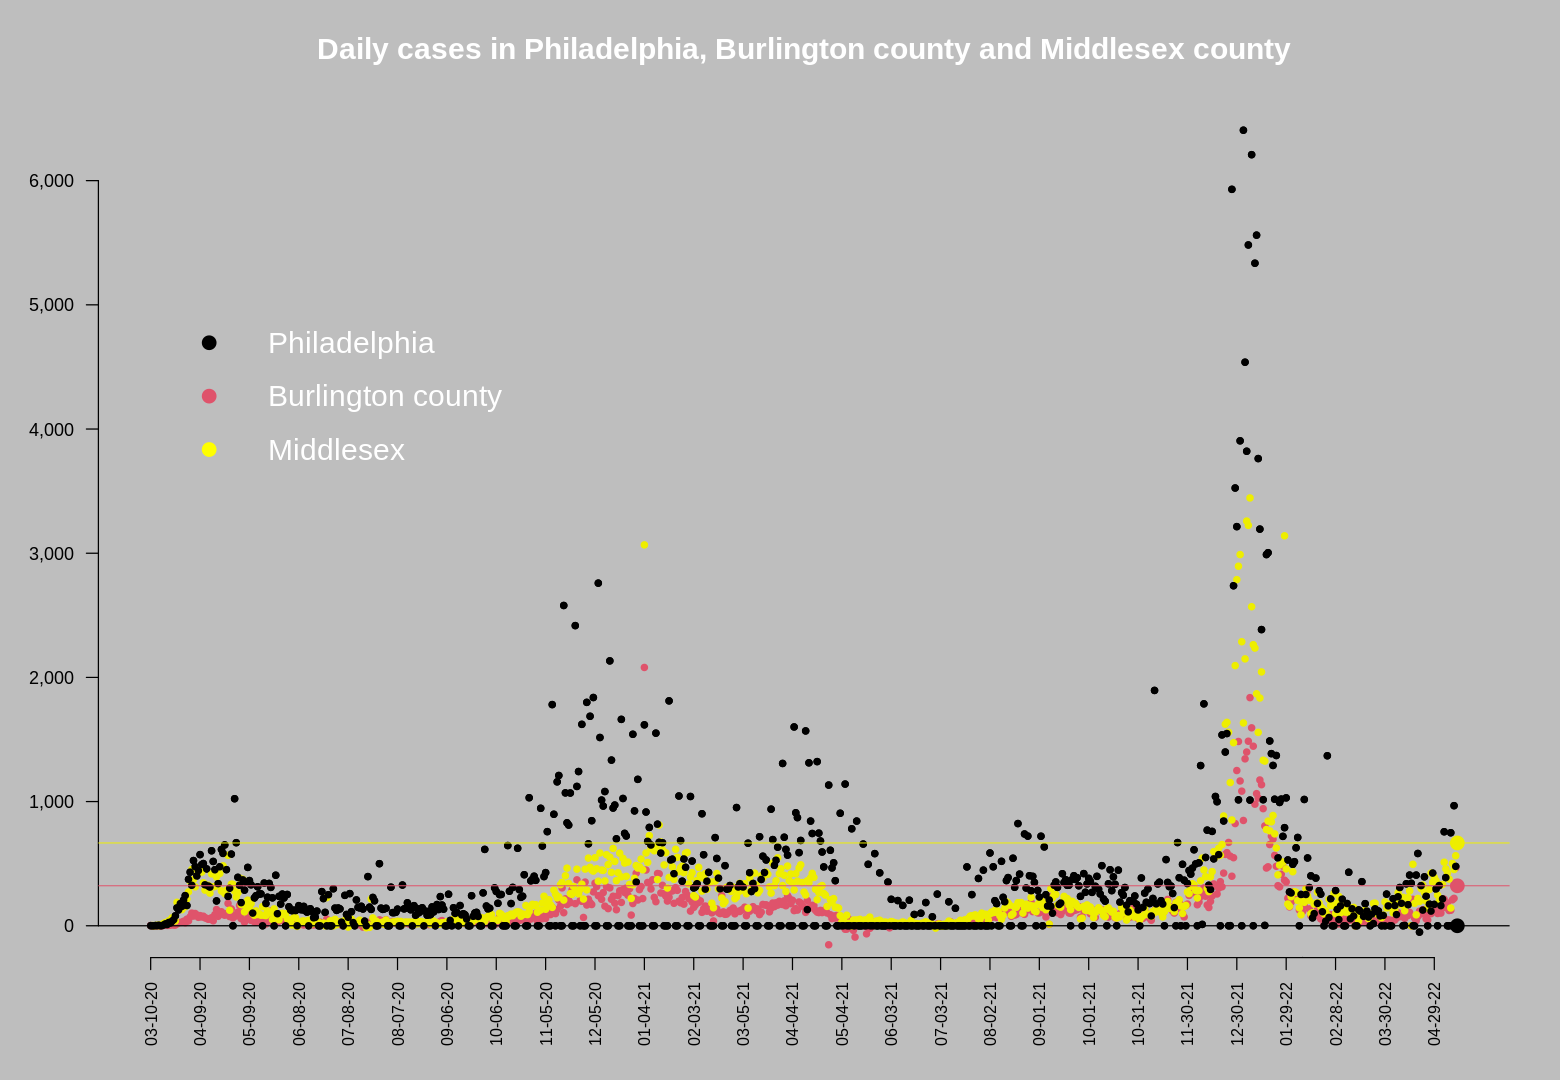

In [49]:
# Daily cases in Philadelphia, Burlington county and Middlesex county:

Philadelphia$daily <- c(Philadelphia$cases[1], diff(Philadelphia$cases,1))

par(bg = 'gray')
with(as.data.frame(Philadelphia),
     plot(date, daily,
          axes=F, xlab="", ylab="", pch=19, 
          cex.axis=0.8, cex=0.7,
          cex.main=1.5, las=2, bty='l', ylim=c(0,max(Philadelphia$daily)),
          main="Daily cases in Philadelphia, Burlington county and Middlesex county",
          col.main='white'))

ats <- seq(trunc(min(Philadelphia$date), "days"), trunc(max(Philadelphia$date), "days"), by="30 days")

axis.POSIXct(1,ats, at=ats,
             labels=format(ats,"%m-%d-%y"),
             las=2, cex.axis=0.8)

at2 <- seq(0, max(Philadelphia$daily) + 100, by=1000)
axis(side=2, at2, las=2, cex.axis=.9, labels = formatC(at2, big.mark = ",", format = "d"))


Burlington$daily <- c(Burlington$cases[1], diff(Burlington$cases,1))
points(Burlington$date, Burlington$daily, pch=19, col=2, cex=.7)
points(last(Burlington$date), last(Burlington$daily), pch=19, col=2, cex=1.5)
Middlesex$daily <- c(Middlesex$cases[1], diff(Middlesex$cases,1))
points(Middlesex$date, Middlesex$daily, pch=19, col='yellow2', cex=0.7)
points(last(Middlesex$date), last(Middlesex$daily), pch=19, col='yellow2', cex=1.5)
points(Philadelphia$date, Philadelphia$daily, pch=19, col=1, cex=0.7)
points(last(Philadelphia$date), last(Philadelphia$daily), pch=19, col=1, cex=1.5)

at1 <- seq(min(Philadelphia$date), last(Philadelphia$date)+1, by="days")
 

legend(Philadelphia$date[1], .8 * max(Philadelphia$daily), bg="transparent",
       legend=c("Philadelphia", "Burlington county", "Middlesex"),
       col=c(1, 2, 'yellow'), cex=1.5, text.col='white',
       pch=c(19,19,19), box.lty=0)

abline(h = tail(Philadelphia$daily,1), col=1)
abline(h = tail(Burlington$daily,1), col='2', lwd=.8)
abline(h = tail(Middlesex$daily,1), col='yellow2', lwd=.8)

In [50]:
tail(Burlington$daily)

[1] 123 125 209 221 466 322

In [51]:
paste(c("New cases in Philadelphia prior: ", "in the last day: "), tail(Philadelphia$daily,2))
paste(c("New cases in Burlington prior: ", "in the last day: "), tail(Burlington$daily,2))
paste(c("New cases in Middlesex prior: ", "in the last day: "), tail(Middlesex$daily,2))
paste(c("The case rate per 100,000 in Burlington county is: "), round((sum(tail(Burlington$daily,7)) / 7) / 445349 * 10^5), ".")
paste(c("The case rate per 100,000 in NJ is: "), round((sum(tail(first.diff.NJ,7))/7)/last_day$pop[which(last_day$state=='New Jersey')] *10^5), ".")
paste(c("The case rate per 100,000 in Philadelphia is: "), round((sum(tail(Philadelphia$daily,7)) / 7) / 5700000 * 10^5), ".")

[1] "New cases in Philadelphia prior:  478"
[2] "in the last day:  0"

[1] "New cases in Burlington prior:  466" "in the last day:  322"

[1] "New cases in Middlesex prior:  564" "in the last day:  667"

[1] "The case rate per 100,000 in Burlington county is:  53 ."

[1] "The case rate per 100,000 in NJ is:  6 ."

[1] "The case rate per 100,000 in Philadelphia is:  5 ."

NOTES ON THE R NAUGHT $R_o$ FACTOR:

$R_0$ assumes  that there are no counter-measures curtail the spread of the virus. It is more relevant to calculate $R_e(t)$: the time-changing effective reproduction factor, measuring, on a given day $t$, how many people does one person infect.



In the SIR model we have three fractions of the population:

$S$ - fraction susceptible to be infected

$I$ - fraction of infected

$R$ - fraction of recovered or dead.

$$S \underset{-\beta SI}\longrightarrow I \underset{\gamma I} \longrightarrow R$$

where $\beta$ is $\frac{\text{average # contacts}}{\text{person }\times\text{ time}}$ and $\gamma$ is $\frac{1}{\text{average time a person is infectious}}.$ 

The three governing equations are:

$$\begin{align}
\dot S &= -\beta IS\\
\dot I &= \beta IS - \gamma I\\
\dot R &= \gamma I
\end{align}$$

Working a bit on the second equation we get

$$\begin{align}
\dot I\rvert_{t=0} &= \beta  I_0 S_0 - \gamma I_0
\end{align}$$

and if $\beta S_0 - \gamma >0$ we will have exponential growth. Equivalently, the condition can be expressed as

$$\frac{\beta}{\gamma} S_0 >1 \implies R_0 > 1$$

with $R_o =\frac{\beta}{\gamma} S_0.$


Over time this value evolves. [Here](https://rt.live/) are the values by state of the $R_t,$ which changes over time with the percentage of susceptibles, and the size of the population, and can be altered by containment measures. Some coarse approximation equations ([here](https://arxiv.org/ftp/arxiv/papers/1603/1603.01216.pdf) and [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6962332/pdf/main.pdf)) to understand the importance of an $R_t<1$ could be:

$$ \bbox[5px,border:2px solid red]
{
R_t=\frac{S(t)}{N}R_o
}
$$

and

$$ \bbox[5px,border:2px solid red]
{
I(t) \approx I(0)\exp\left(\gamma\left (R_t-1\right)t\right)
}
$$

